# Plot Time Series w/ Observations (To get siphcat to get the text files -- USE THIS ONE!)

## Libraries

In [1]:
####################################################
####################################################
####################################################
#
# Libraries
#

import numpy             as np
import datetime          as datetime
import os                as os
import platform          as platform
import xarray            as xr
import pandas            as pd
import glob              as glob
import siphon.catalog    as siphcat  
import siphon.ncss       as siphncss
import seaborn           as sns
import matplotlib.pyplot as plt
import pint_xarray       as px
import pint              as pint
import matplotlib.dates  as mdates
import timezonefinder    as tzf
import pytz              as pytz
import haversine         as hs
import socket            as socket
import metpy.calc        as mpcalc
import metpy.units       as mpunits
import pathlib           as pathlib

import urllib.request
import shutil

import matplotlib.font_manager as fm
import matplotlib as mpl
import metpy.io          as mpio


from requests import HTTPError


from metpy.units import units

import airportsdata as airpt

ureg = pint.UnitRegistry()
Q_ = ureg.Quantity


def haversine(row):
    lon1 = station_lon
    lat1 = station_lat
    lon2 = row['longitude']
    lat2 = row['latitude']
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    km = 6367 * c
    return km
    
    
#
####################################################
####################################################
####################################################

## File Organization

In [2]:
####################################################
####################################################
####################################################
#
# File Organization
#

beta_on     = 0
max_domains = 2

if (socket.gethostname() == "kyrill"):
    WRF_OVERALL_DIR = "/projects/SD_Mines_WRF_REALTIME/"
else:
    if (platform.system() == "Darwin"):
         WRF_OVERALL_DIR = "/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/"
    else:
         WRF_OVERALL_DIR = "/home/wjc/GitHub/SD_Mines_WRF_REALTIME/"


os.chdir(WRF_OVERALL_DIR)

print( "Current Working Directory is now " + os.getcwd() )
    
WPS_WORK    = WRF_OVERALL_DIR + "./WPS_PrepArea/"
WPS_EXE     = WRF_OVERALL_DIR + "./WRF4/WPS/"
WRF_EXE     = WRF_OVERALL_DIR + "./WRF4/WRF/test/em_real/"
WRF_ARCHIVE = WRF_OVERALL_DIR + "./ARCHIVE/"
WRF_IMAGES  = WRF_OVERALL_DIR + "./WEB_IMAGES/"
METAR_DIR   = WRF_OVERALL_DIR + "./METARS/"



station_list_file = WRF_OVERALL_DIR + "namelist_files_and_local_scripts/time_series_station_files_"+str(max_domains)+"_dom_all.xlsx"

os.chdir(WRF_EXE)

#
####################################################
####################################################
####################################################

Current Working Directory is now /Users/wjc/GitHub/SD_Mines_WRF_REALTIME


## Time Control

In [3]:
####################################################
####################################################
####################################################
#
# Model Start Date
#

with open(WRF_ARCHIVE  + "./current_complete_run/current_run.txt") as f:
    model_start_date_YYYY_MM_DD_HH = f.readlines()

model_start_date_YYYY_MM_DD_HH     = model_start_date_YYYY_MM_DD_HH[0][0:13]

model_start_date_YYYY_MM_DD_HH0000 = model_start_date_YYYY_MM_DD_HH + ":00:00"
print(model_start_date_YYYY_MM_DD_HH0000)
    
model_start_datetime = datetime.datetime.strptime(model_start_date_YYYY_MM_DD_HH0000, '%Y-%m-%d_%H:%M:%S')
print("Model Simulation Date ", model_start_datetime)
    
model_end_datetime   = model_start_datetime + datetime.timedelta(hours=36)
current_datetime     = datetime.datetime.utcnow()
siphon_end_datetime  = min(current_datetime,model_end_datetime)

print("         Model Start Datetime is ", model_start_datetime)
print("           Model End Datetime is ",   model_end_datetime)
print("             Current Datetime is ",     current_datetime)
print("          Siphon End Datetime is ",  siphon_end_datetime)


siphon_time_series       = pd.date_range(model_start_datetime, siphon_end_datetime,freq='H')
siphon_pulls_YYYYMMDD_HH = siphon_time_series.strftime("%Y%m%d_%H00")

print(siphon_pulls_YYYYMMDD_HH)

#
####################################################
####################################################
####################################################

2022-09-29_18:00:00
Model Simulation Date  2022-09-29 18:00:00
         Model Start Datetime is  2022-09-29 18:00:00
           Model End Datetime is  2022-10-01 06:00:00
             Current Datetime is  2022-09-30 02:57:29.996515
          Siphon End Datetime is  2022-09-30 02:57:29.996515
Index(['20220929_1800', '20220929_1900', '20220929_2000', '20220929_2100',
       '20220929_2200', '20220929_2300', '20220930_0000', '20220930_0100',
       '20220930_0200'],
      dtype='object')


## Read tslist excel file



In [4]:
####################################################
####################################################
####################################################
#
# Read TSLIST Excel File
#

print("read file from "+station_list_file)

available_time_series_list = pd.read_excel(station_list_file,
                                           index_col=0)

print(available_time_series_list)

#
####################################################
####################################################
####################################################

read file from /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/namelist_files_and_local_scripts/time_series_station_files_2_dom_all.xlsx
          Station ID  Domain            Station Name  Latitude  Longitude  \
Row Label                                                                   
26              KUNR       2      Rapid City NWS, SD   44.0727   -103.211   
21              KRCA       2       Ellsworth AFB, SD   44.1330   -103.100   
20              KRAP       2     Rapid City Arpt, SD   44.0430   -103.054   
25              KUDX       2  Rapid City, NEXRAD, SD   44.1330   -102.833   
7               KCUT       2         Custer Arpt, SD   43.7330   -103.611   
23              KSPF       2     Clyde Ice Field, SD   44.4830   -103.783   
10              KEFC       2  Belle Fourche Muni, SD   44.7340   -103.862   
6               KCDR       2     Chadron Airport, NE   42.8370   -103.098   
15              KIEN       2     Pine Ridge Arpt, SD   43.0210   -102.518   
28              KW43    

## Get Station Information

In [5]:
####################################################
####################################################
####################################################
#
# Airport Data
#

airport_database = airpt.load('ICAO')

#
####################################################
####################################################
####################################################

## Pull METARS from Siphon Services

In [6]:
####################################################
####################################################
####################################################
#
# Pull METARS from UNIDATA NOAAPORT Experimental Site
#
# https://thredds-test.unidata.ucar.edu/thredds/fileServer/noaaport/text/metar/metar_20210924_0000.txt


try: 
    cat = siphcat.TDSCatalog('https://thredds-dev.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.xml')

    first = True
    for datehour in siphon_pulls_YYYYMMDD_HH:



        metar_url  = "https://thredds-dev.unidata.ucar.edu/thredds/fileServer/noaaport/text/metar/metar_"+datehour+".txt"
        metar_file = METAR_DIR + "./metar_"+datehour+".txt"


        path_to_file = pathlib.Path(metar_file)

        print(path_to_file, path_to_file.is_file())



        if (not path_to_file.is_file()) :

            print("downloading "+ metar_url)
            with urllib.request.urlopen(metar_url) as response, open(metar_file, 'wb') as out_file:
                shutil.copyfileobj(response, out_file)
        print("cracking "+metar_file)
        try:
            indata = mpio.metar.parse_metar_file(metar_file)
            if first:
                first = False
                metar_dataframe = indata
            else:
                metar_dataframe = pd.concat([metar_dataframe,indata])
                metar_dataframe = metar_dataframe.drop_duplicates()
        except ValueError:
            print("BALLS! Parse Error")
            error_404 = True
            pass




    metar_station_locs = metar_dataframe[["station_id","latitude","longitude"]].drop_duplicates()

except:
    print("Balls - we cannot access the thredds server")
    metar_dataframe = pd.DataFrame()

#
####################################################
####################################################
####################################################

/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220929_1800.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220929_1800.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220929_1900.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220929_1900.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220929_2000.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220929_2000.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220929_2100.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220929_2100.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220929_2200.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220929_2200.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/METARS/metar_20220929_2300.txt True
cracking /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./METARS/./metar_20220929_2300.txt
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/

## Rotate through Available Files

Creating /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./WEB_IMAGES/./current_complete_run/STATION_TIME_SERIES/
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KUNR.nc
Weatherstation from airport database  Ellsworth Air Force Base
lon metar/station/wrf: -103.08 -103.211 [-103.201]
lat metar/station/wrf: 44.13 44.0727 [44.064]
distance between  metar and tslist  12.248076856135103
distance between  metar and    wrf  12.133622306515543
distance between tslist and    wrf  1.2546616892833835
DatetimeIndex(['2022-09-29 11:55:00-06:00', '2022-09-29 12:55:00-06:00',
               '2022-09-29 13:55:00-06:00', '2022-09-29 14:55:00-06:00',
               '2022-09-29 15:55:00-06:00', '2022-09-29 16:55:00-06:00',
               '2022-09-29 17:55:00-06:00', '2022-09-29 18:55:00-06:00',
               '2022-09-29 19:55:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='date_time', freq=None)
                    s

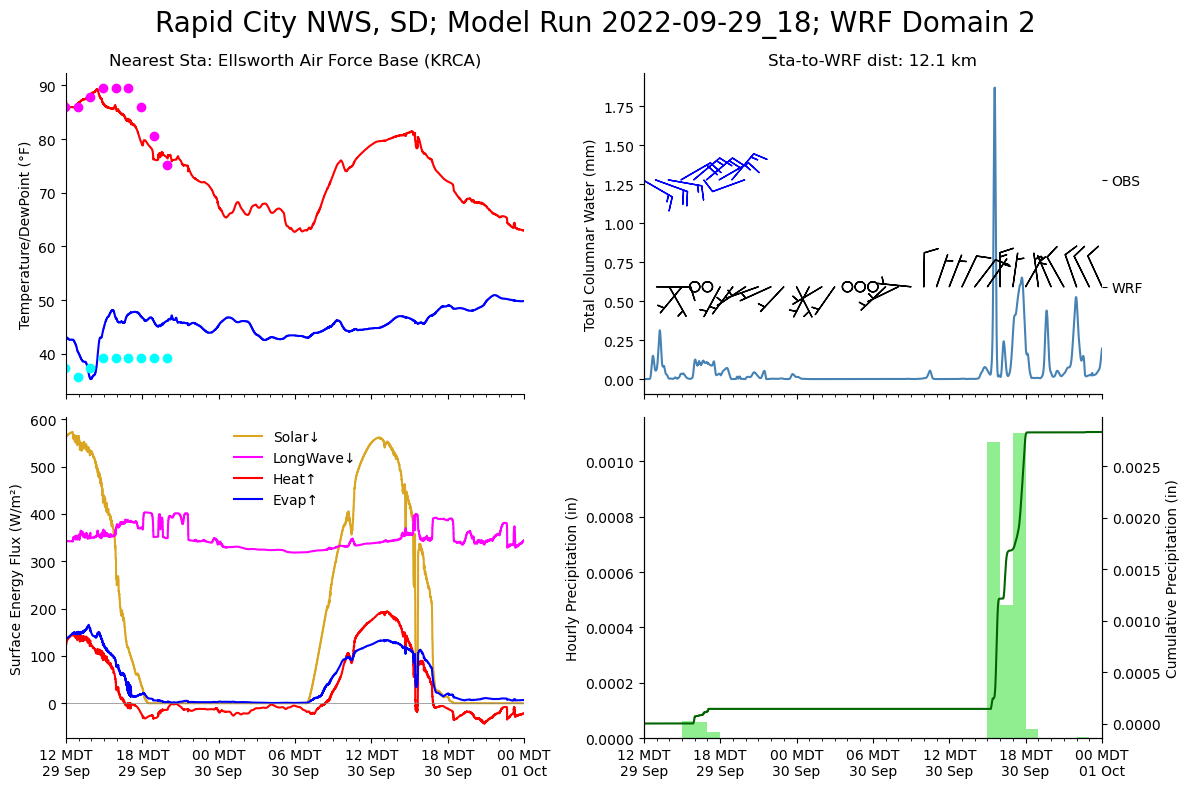

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KRCA.nc
Weatherstation from airport database  Ellsworth Air Force Base
lon metar/station/wrf: -103.08 -103.1 [-103.088]
lat metar/station/wrf: 44.13 44.133 [44.146]
distance between  metar and tslist  1.6306763023763868
distance between  metar and    wrf  1.8901944284525458
distance between tslist and    wrf  1.7339386800389782
DatetimeIndex(['2022-09-29 11:55:00-06:00', '2022-09-29 12:55:00-06:00',
               '2022-09-29 13:55:00-06:00', '2022-09-29 14:55:00-06:00',
               '2022-09-29 15:55:00-06:00', '2022-09-29 16:55:00-06:00',
               '2022-09-29 17:55:00-06:00', '2022-09-29 18:55:00-06:00',
               '2022-09-29 19:55:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='date_time', freq=None)
                    station_id  latitude  longitude  elevation  \
date_time                                                     

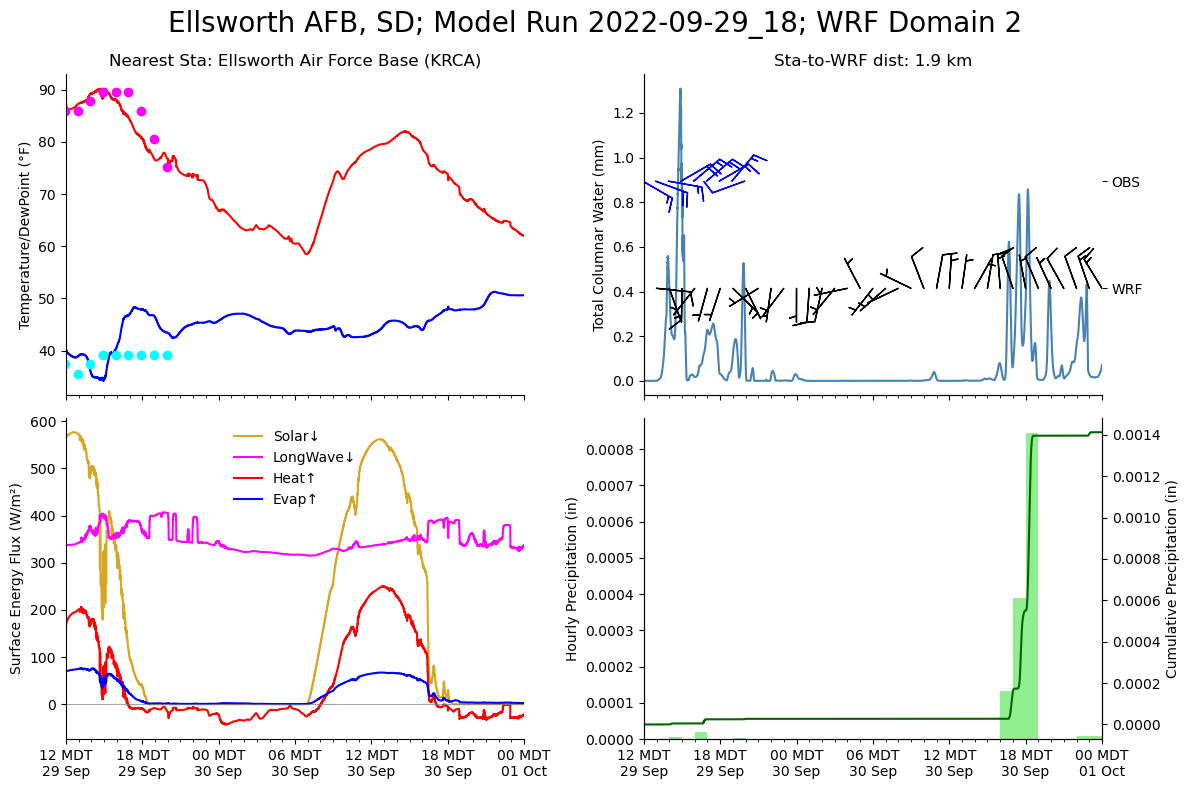

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KRAP.nc
Weatherstation from airport database  Rapid City Regional Airport
lon metar/station/wrf: -103.05 -103.054 [-103.05]
lat metar/station/wrf: 44.05 44.043 [44.038]
distance between  metar and tslist  0.8414626128192473
distance between  metar and    wrf  1.3343409628024534
distance between tslist and    wrf  0.6413546080681104
DatetimeIndex(['2022-09-29 11:52:00-06:00', '2022-09-29 12:52:00-06:00',
               '2022-09-29 13:52:00-06:00', '2022-09-29 14:52:00-06:00',
               '2022-09-29 15:52:00-06:00', '2022-09-29 16:52:00-06:00',
               '2022-09-29 17:52:00-06:00', '2022-09-29 18:52:00-06:00',
               '2022-09-29 19:52:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='date_time', freq=None)
                    station_id  latitude  longitude  elevation  \
date_time                                                 

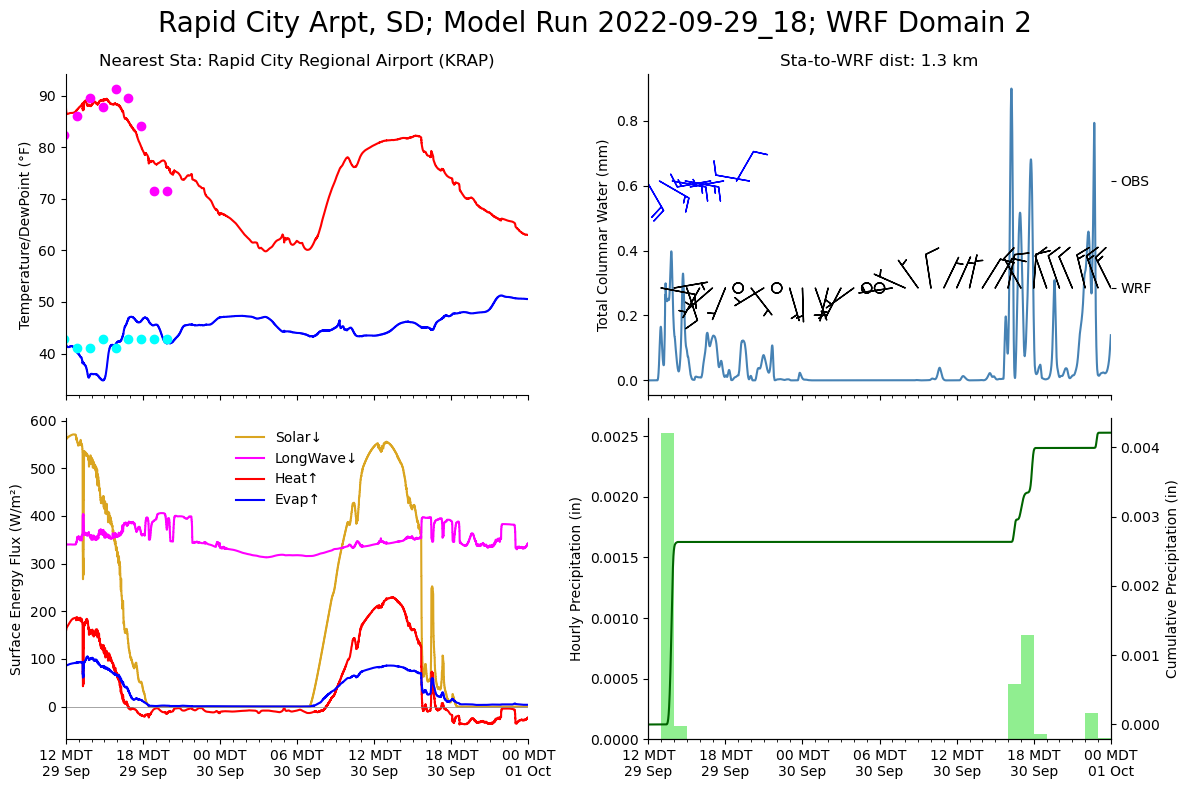

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KUDX.nc
Weatherstation from airport database  Rapid City Regional Airport
lon metar/station/wrf: -103.05 -102.833 [-102.825]
lat metar/station/wrf: 44.05 44.133 [44.146]
distance between  metar and tslist  19.634671810868664
distance between  metar and    wrf  20.89914758750576
distance between tslist and    wrf  1.580226623927318
DatetimeIndex(['2022-09-29 11:52:00-06:00', '2022-09-29 12:52:00-06:00',
               '2022-09-29 13:52:00-06:00', '2022-09-29 14:52:00-06:00',
               '2022-09-29 15:52:00-06:00', '2022-09-29 16:52:00-06:00',
               '2022-09-29 17:52:00-06:00', '2022-09-29 18:52:00-06:00',
               '2022-09-29 19:52:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='date_time', freq=None)
                    station_id  latitude  longitude  elevation  \
date_time                                                  

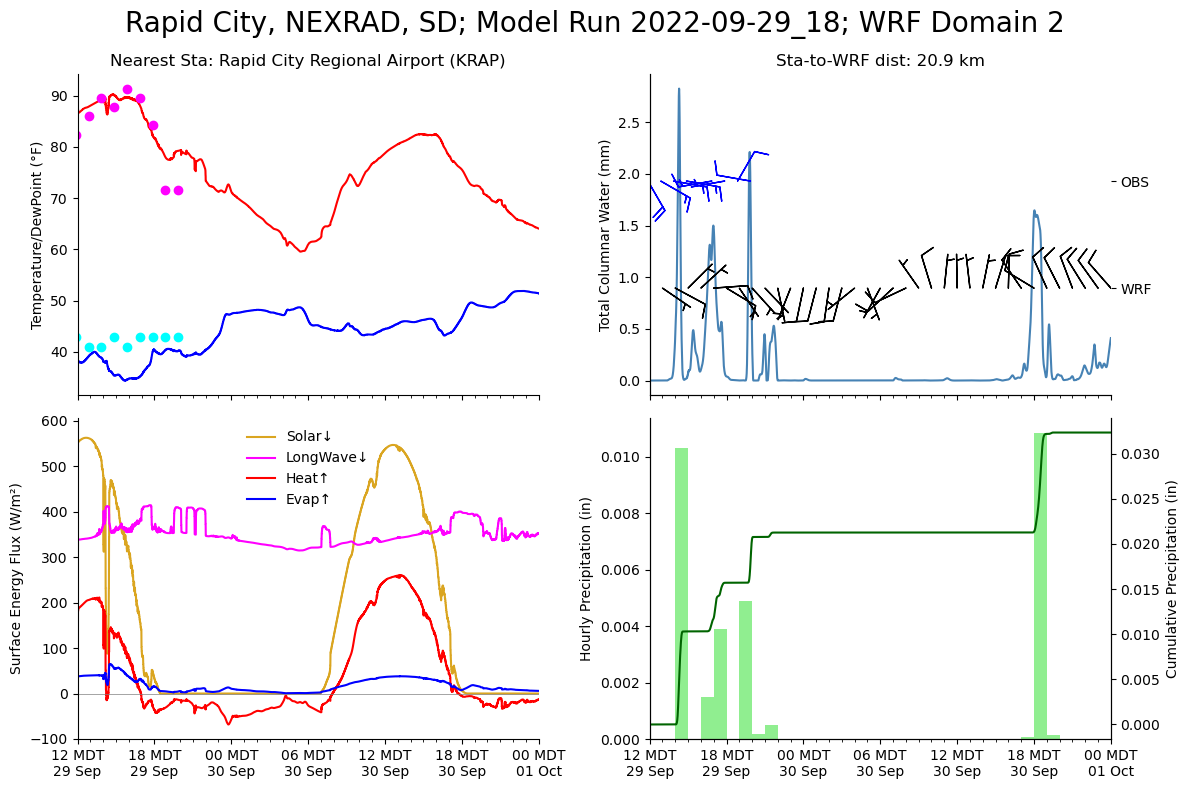

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KCUT.nc
Weatherstation from airport database  Custer County Airport
lon metar/station/wrf: -103.62 -103.611 [-103.609]
lat metar/station/wrf: 43.73 43.733 [43.738]
distance between  metar and tslist  0.7963672843281203
distance between  metar and    wrf  1.253956782361837
distance between tslist and    wrf  0.5787300692258683
DatetimeIndex(['2022-09-29 11:53:00-06:00', '2022-09-29 12:53:00-06:00',
               '2022-09-29 13:53:00-06:00', '2022-09-29 14:53:00-06:00',
               '2022-09-29 15:53:00-06:00', '2022-09-29 16:53:00-06:00',
               '2022-09-29 17:53:00-06:00', '2022-09-29 18:53:00-06:00',
               '2022-09-29 19:53:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='date_time', freq=None)
                    station_id  latitude  longitude  elevation  \
date_time                                                       

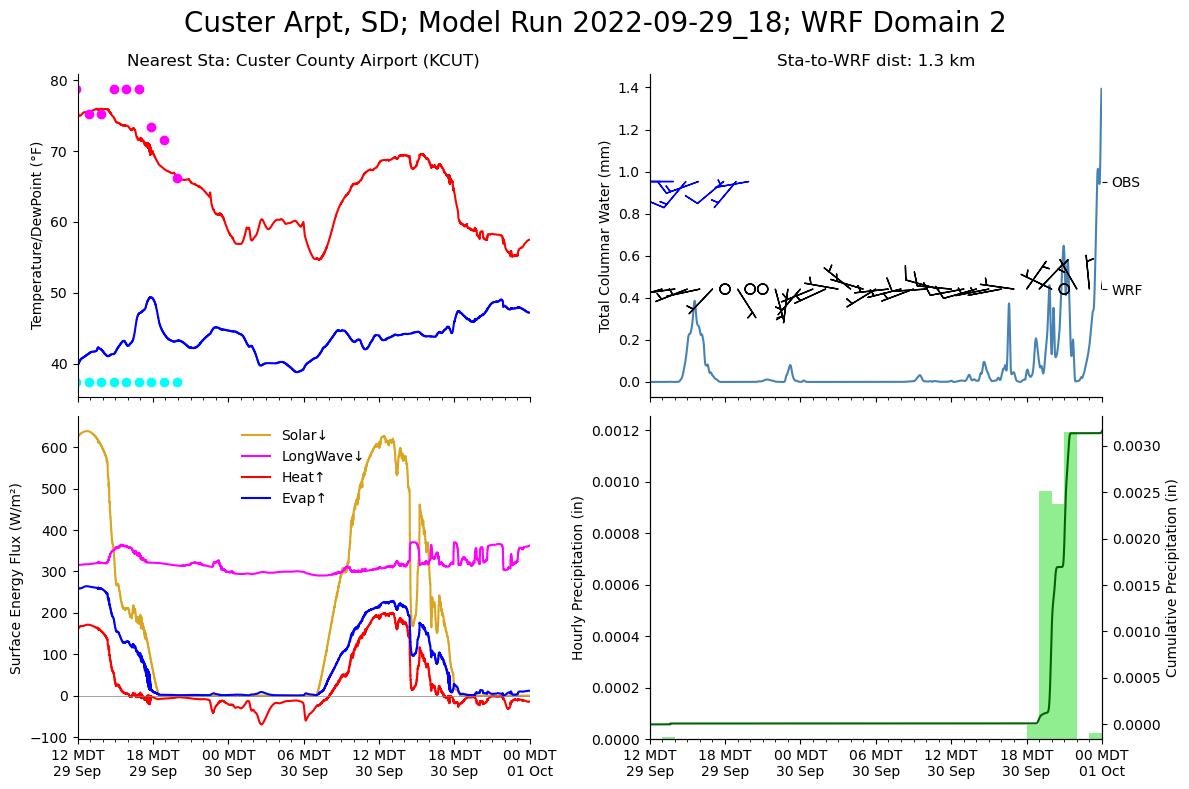

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KSPF.nc
Weatherstation from airport database  Black Hills Clyde Ice Field
lon metar/station/wrf: -103.77 -103.783 [-103.771]
lat metar/station/wrf: 44.47 44.483 [44.492]
distance between  metar and tslist  1.7757963329263085
distance between  metar and    wrf  2.447577897868054
distance between tslist and    wrf  1.381184271598091
DatetimeIndex(['2022-09-29 11:55:00-06:00', '2022-09-29 12:15:00-06:00',
               '2022-09-29 12:35:00-06:00', '2022-09-29 12:55:00-06:00',
               '2022-09-29 13:15:00-06:00', '2022-09-29 13:35:00-06:00',
               '2022-09-29 13:55:00-06:00', '2022-09-29 14:15:00-06:00',
               '2022-09-29 14:35:00-06:00', '2022-09-29 14:55:00-06:00',
               '2022-09-29 15:15:00-06:00', '2022-09-29 15:35:00-06:00',
               '2022-09-29 15:55:00-06:00', '2022-09-29 16:15:00-06:00',
               '2022-09-29 16:35:0

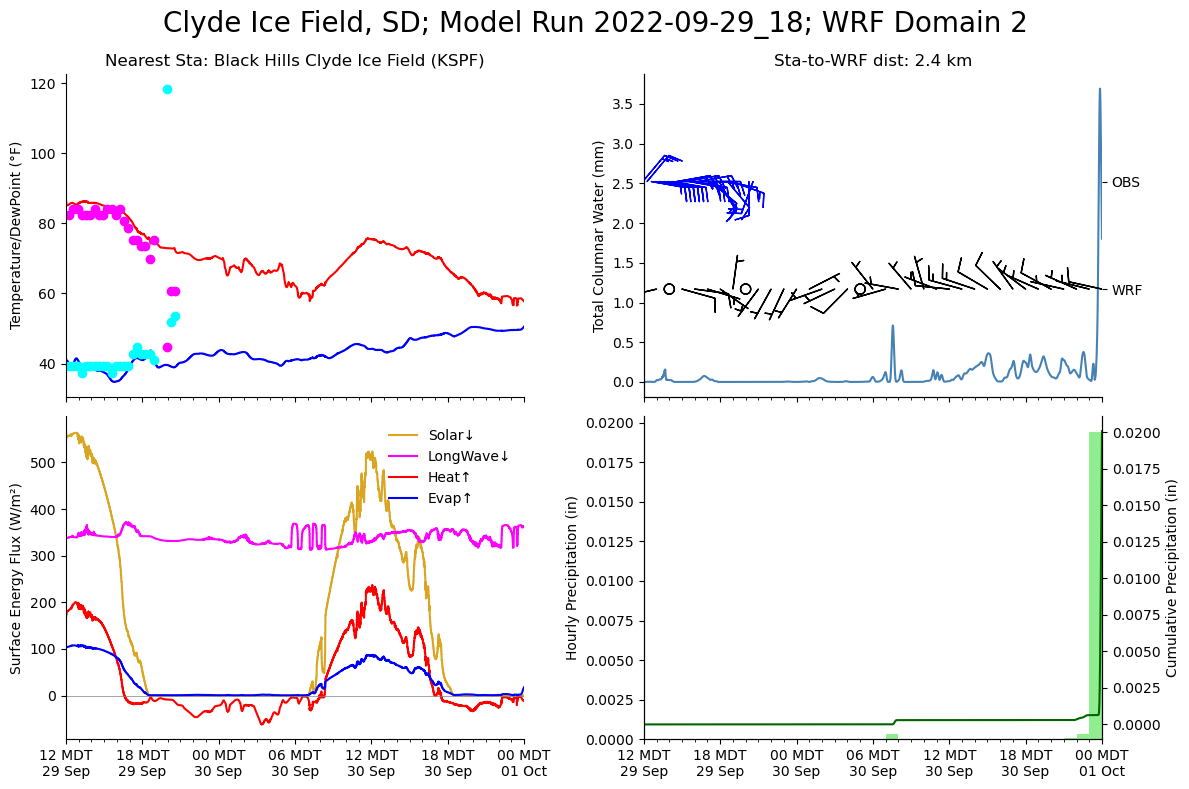

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KEFC.nc
Weatherstation from airport database  Black Hills Clyde Ice Field
lon metar/station/wrf: -103.77 -103.862 [-103.852]
lat metar/station/wrf: 44.47 44.734 [44.735]
distance between  metar and tslist  30.245626446148954
distance between  metar and    wrf  30.17335889793137
distance between tslist and    wrf  0.797691047828645
DatetimeIndex(['2022-09-29 11:55:00-06:00', '2022-09-29 12:15:00-06:00',
               '2022-09-29 12:35:00-06:00', '2022-09-29 12:55:00-06:00',
               '2022-09-29 13:15:00-06:00', '2022-09-29 13:35:00-06:00',
               '2022-09-29 13:55:00-06:00', '2022-09-29 14:15:00-06:00',
               '2022-09-29 14:35:00-06:00', '2022-09-29 14:55:00-06:00',
               '2022-09-29 15:15:00-06:00', '2022-09-29 15:35:00-06:00',
               '2022-09-29 15:55:00-06:00', '2022-09-29 16:15:00-06:00',
               '2022-09-29 16:35:0

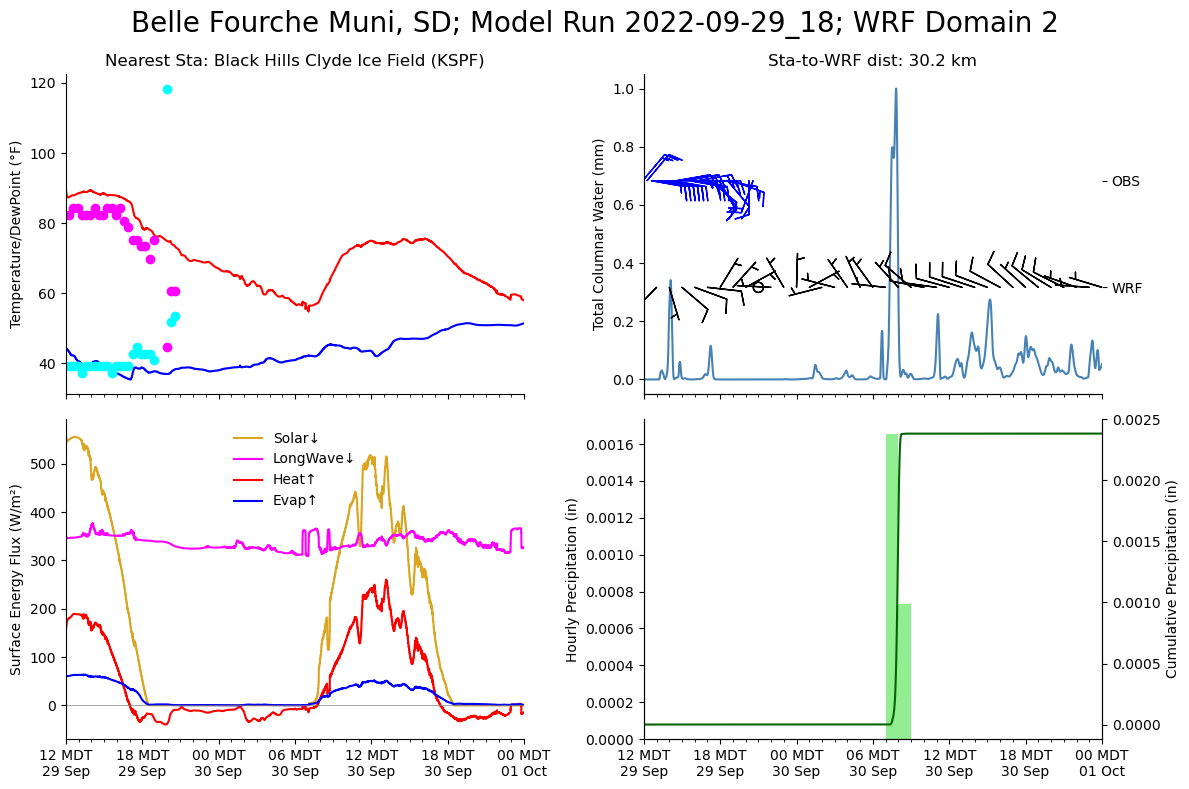

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KCDR.nc
Weatherstation from airport database  Chadron Municipal Airport
lon metar/station/wrf: -103.1 -103.098 [-103.081]
lat metar/station/wrf: 42.83 42.837 [42.824]
distance between  metar and tslist  0.7952672301072319
distance between  metar and    wrf  1.6870098978676618
distance between tslist and    wrf  2.002846889466035
DatetimeIndex(['2022-09-29 11:53:00-06:00', '2022-09-29 12:53:00-06:00',
               '2022-09-29 13:53:00-06:00', '2022-09-29 14:53:00-06:00',
               '2022-09-29 15:53:00-06:00', '2022-09-29 16:51:00-06:00',
               '2022-09-29 16:53:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='date_time', freq=None)
                    station_id  latitude  longitude  elevation  \
date_time                                                        
2022-09-29 17:53:00       KCDR     42.83     -103.1     1010.0   
20

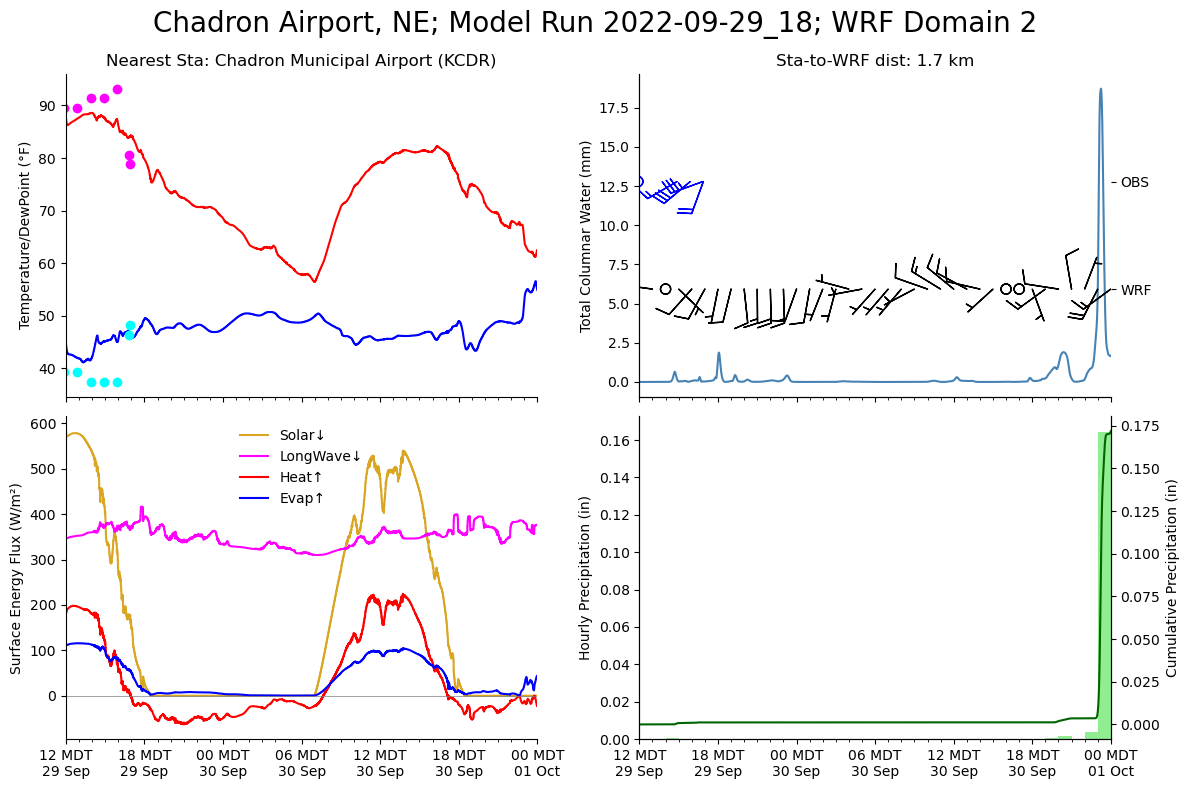

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KIEN.nc
Weatherstation from airport database  Pine Ridge Airport
lon metar/station/wrf: -102.52 -102.518 [-102.529]
lat metar/station/wrf: 43.03 43.021 [43.013]
distance between  metar and tslist  1.0138756011863506
distance between  metar and    wrf  2.0269701563286637
distance between tslist and    wrf  1.261387754002912
DatetimeIndex(['2022-09-29 11:52:00-06:00', '2022-09-29 12:52:00-06:00',
               '2022-09-29 13:52:00-06:00', '2022-09-29 14:52:00-06:00',
               '2022-09-29 15:20:00-06:00', '2022-09-29 15:43:00-06:00',
               '2022-09-29 15:52:00-06:00', '2022-09-29 16:52:00-06:00',
               '2022-09-29 17:52:00-06:00', '2022-09-29 18:41:00-06:00',
               '2022-09-29 18:52:00-06:00', '2022-09-29 19:52:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='date_time', freq=None)
                    station_id 

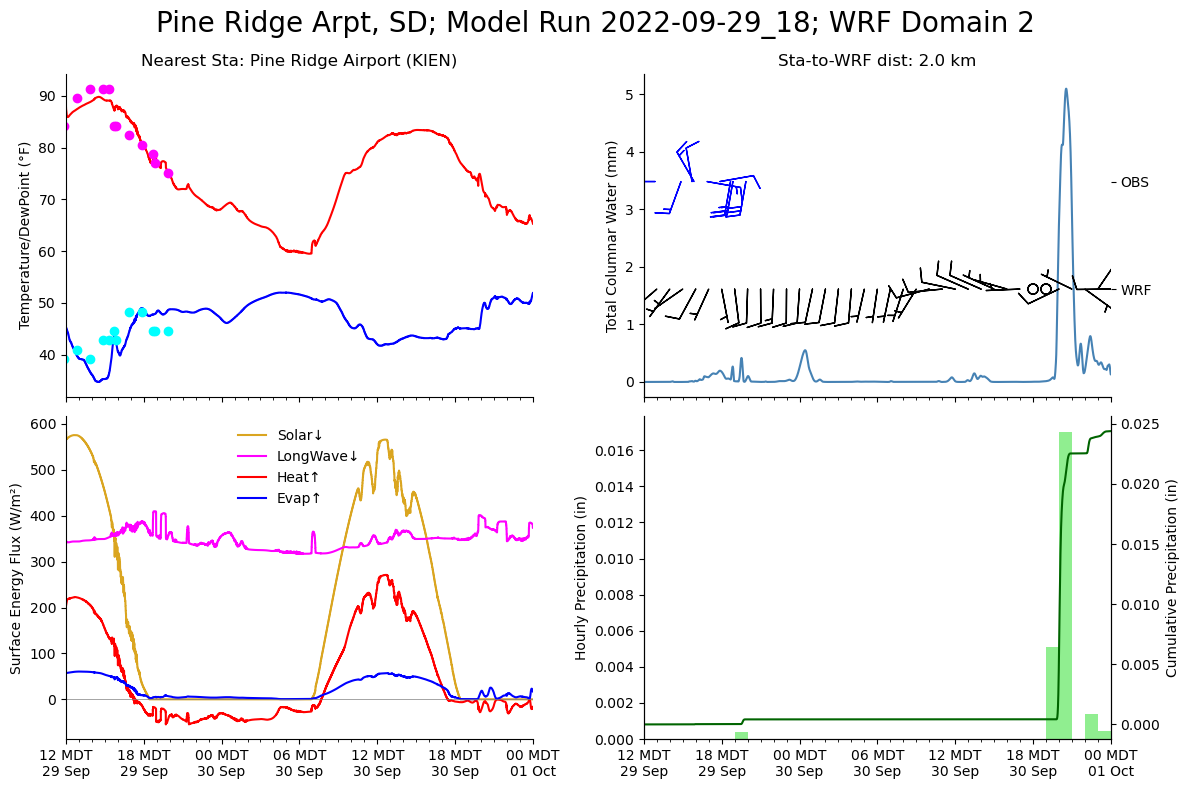

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KW43.nc
Weatherstation from airport database  Hulett Municipal Airport
lon metar/station/wrf: -104.57 -104.568 [-104.571]
lat metar/station/wrf: 44.67 44.6629 [44.671]
distance between  metar and tslist  0.8051728253837324
distance between  metar and    wrf  0.1364464101921689
distance between tslist and    wrf  0.9314027696001868
DatetimeIndex(['2022-09-29 12:15:00-06:00', '2022-09-29 12:35:00-06:00',
               '2022-09-29 11:55:00-06:00', '2022-09-29 12:55:00-06:00',
               '2022-09-29 13:15:00-06:00', '2022-09-29 13:35:00-06:00',
               '2022-09-29 13:55:00-06:00', '2022-09-29 14:15:00-06:00',
               '2022-09-29 14:35:00-06:00', '2022-09-29 14:55:00-06:00',
               '2022-09-29 15:15:00-06:00', '2022-09-29 15:35:00-06:00',
               '2022-09-29 15:55:00-06:00', '2022-09-29 16:15:00-06:00',
               '2022-09-29 16:35:0

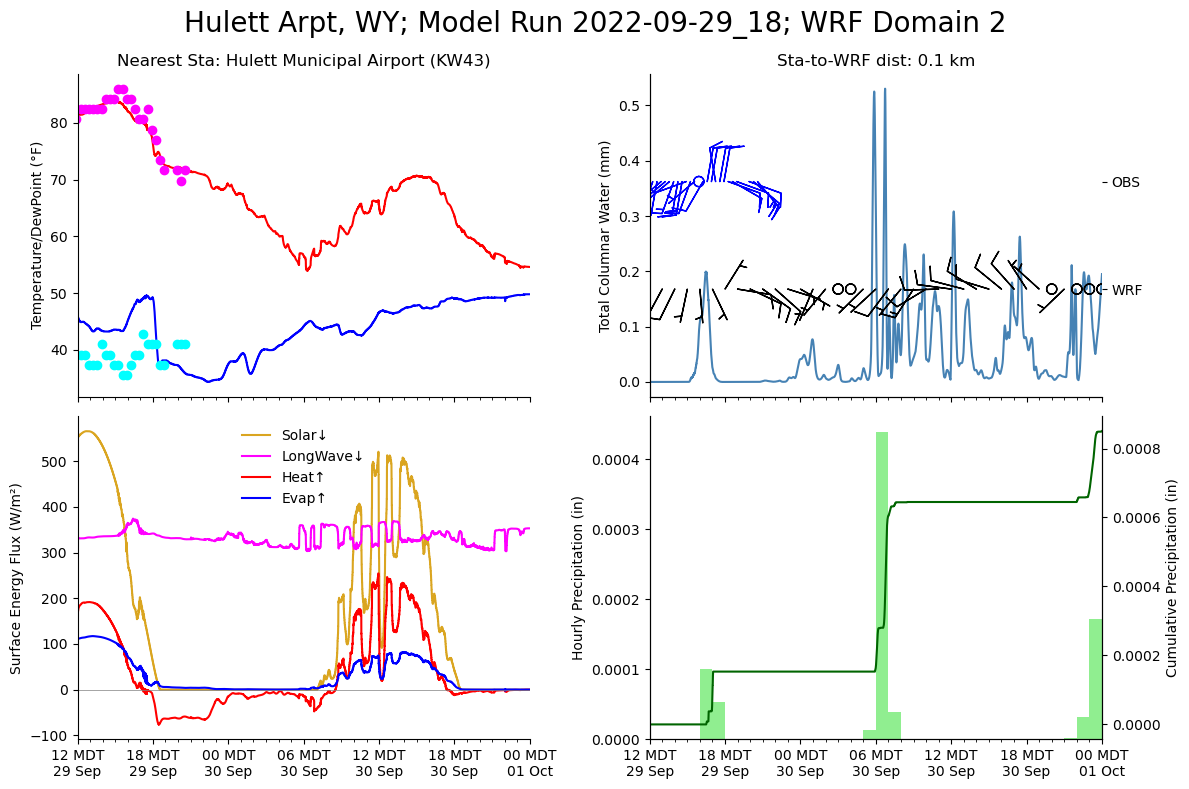

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KD07.nc
Weatherstation from airport database  Faith Municipal Airport
lon metar/station/wrf: -102.02 -102.019 [-102.025]
lat metar/station/wrf: 45.03 45.032 [45.034]
distance between  metar and tslist  0.23586620497680477
distance between  metar and    wrf  0.5934738563248113
distance between tslist and    wrf  0.5213053234830398
DatetimeIndex(['2022-09-29 11:56:00-06:00', '2022-09-29 12:56:00-06:00',
               '2022-09-29 12:56:00-06:00', '2022-09-29 13:56:00-06:00',
               '2022-09-29 13:56:00-06:00', '2022-09-29 14:56:00-06:00',
               '2022-09-29 14:56:00-06:00', '2022-09-29 15:56:00-06:00',
               '2022-09-29 16:56:00-06:00', '2022-09-29 16:56:00-06:00',
               '2022-09-29 17:56:00-06:00', '2022-09-29 17:56:00-06:00',
               '2022-09-29 18:56:00-06:00', '2022-09-29 18:56:00-06:00',
               '2022-09-29 19:56:00

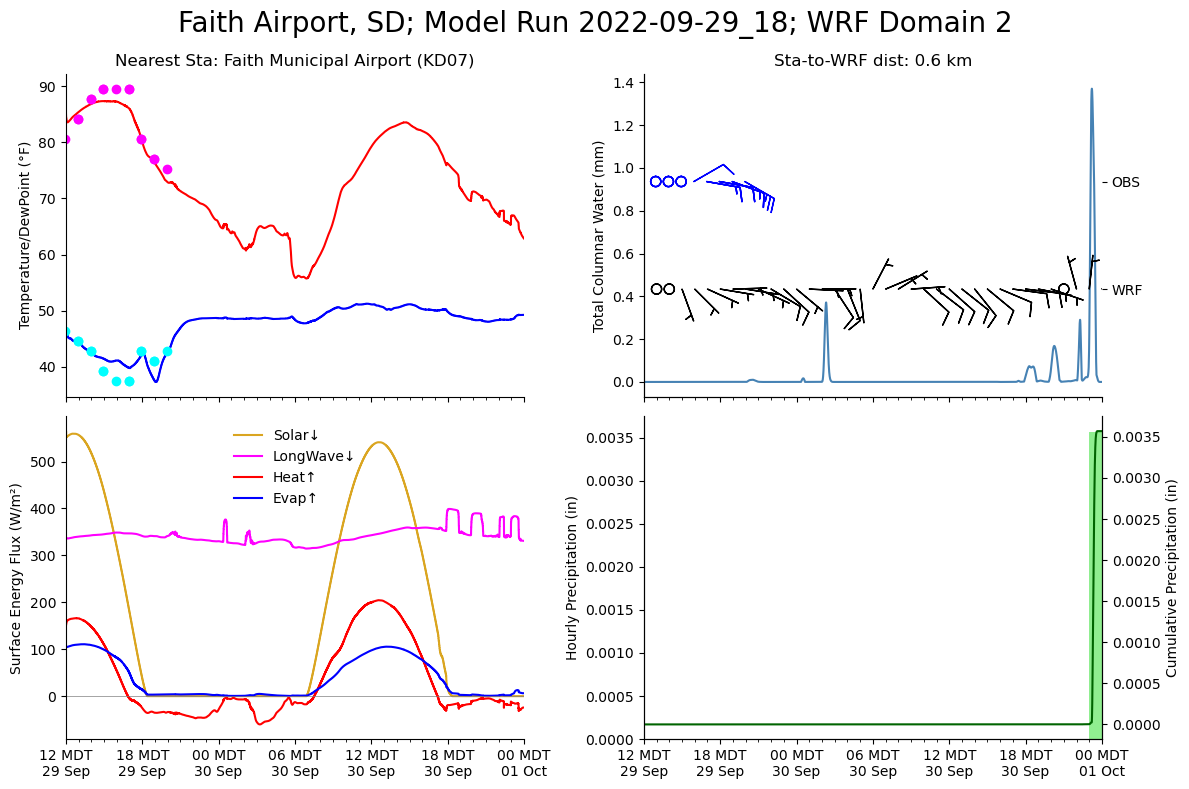

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_K2WX.nc
Weatherstation from short table  K2WX
lon metar/station/wrf: -103.55 -103.546 [-103.56]
lat metar/station/wrf: 45.6 45.604 [45.6]
distance between  metar and tslist  0.5428313569026182
distance between  metar and    wrf  0.7779912123453261
distance between tslist and    wrf  1.1764670823789947
DatetimeIndex(['2022-09-29 11:56:00-06:00', '2022-09-29 12:56:00-06:00',
               '2022-09-29 13:56:00-06:00', '2022-09-29 13:56:00-06:00',
               '2022-09-29 14:56:00-06:00', '2022-09-29 14:56:00-06:00',
               '2022-09-29 15:56:00-06:00', '2022-09-29 15:56:00-06:00',
               '2022-09-29 16:56:00-06:00', '2022-09-29 16:56:00-06:00',
               '2022-09-29 17:56:00-06:00', '2022-09-29 17:56:00-06:00',
               '2022-09-29 18:56:00-06:00', '2022-09-29 19:56:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='dat

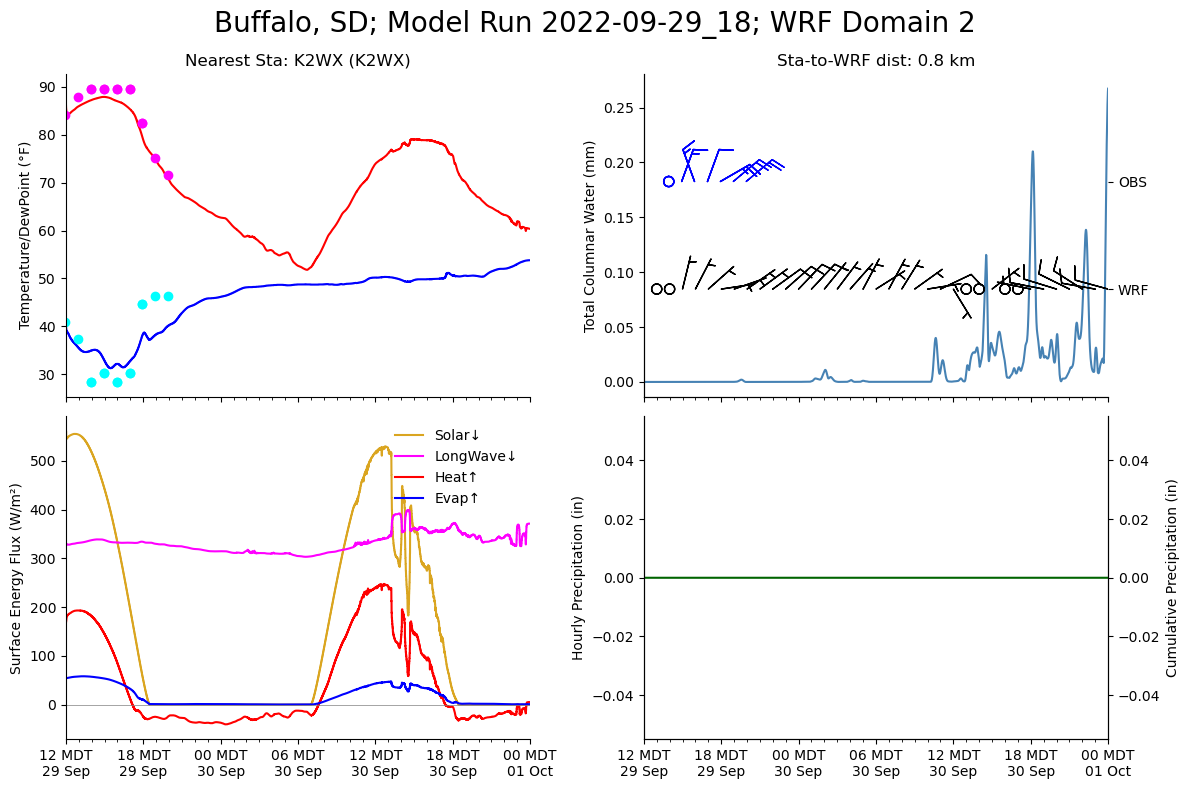

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KPHP.nc
Weatherstation from airport database  Philip Airport
lon metar/station/wrf: -101.6 -101.601 [-101.586]
lat metar/station/wrf: 44.05 44.051 [44.059]
distance between  metar and tslist  0.13693568566437198
distance between  metar and    wrf  1.5010669513782708
distance between tslist and    wrf  1.492709910775782
DatetimeIndex(['2022-09-29 11:55:00-06:00', '2022-09-29 12:55:00-06:00',
               '2022-09-29 13:55:00-06:00', '2022-09-29 14:55:00-06:00',
               '2022-09-29 15:55:00-06:00', '2022-09-29 16:55:00-06:00',
               '2022-09-29 17:55:00-06:00', '2022-09-29 18:55:00-06:00',
               '2022-09-29 19:55:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='date_time', freq=None)
                    station_id  latitude  longitude  elevation  \
date_time                                                        
2022-

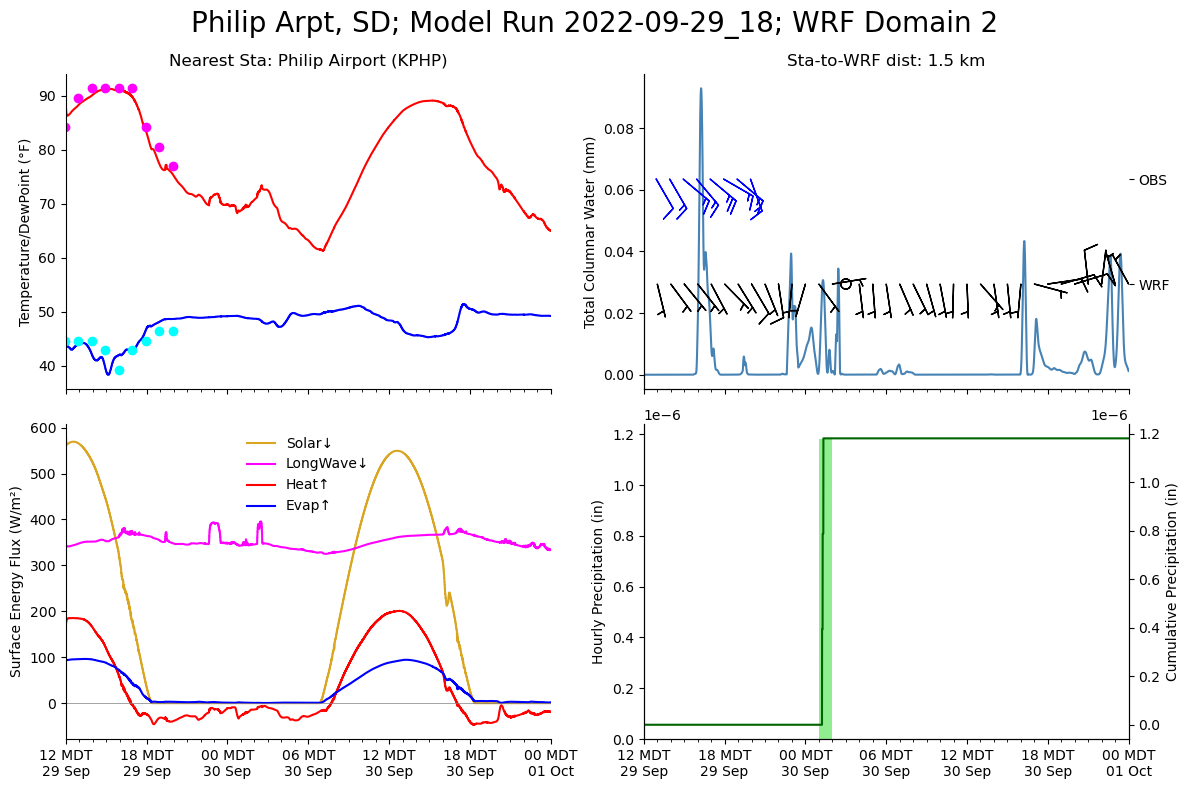

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KGRN.nc
Weatherstation from airport database  Pine Ridge Airport
lon metar/station/wrf: -102.52 -102.175 [-102.162]
lat metar/station/wrf: 43.03 42.806 [42.796]
distance between  metar and tslist  37.545330184291736
distance between  metar and    wrf  39.0770902971485
distance between tslist and    wrf  1.5366653826675085
DatetimeIndex(['2022-09-29 11:52:00-06:00', '2022-09-29 12:52:00-06:00',
               '2022-09-29 13:52:00-06:00', '2022-09-29 14:52:00-06:00',
               '2022-09-29 15:20:00-06:00', '2022-09-29 15:43:00-06:00',
               '2022-09-29 15:52:00-06:00', '2022-09-29 16:52:00-06:00',
               '2022-09-29 17:52:00-06:00', '2022-09-29 18:41:00-06:00',
               '2022-09-29 18:52:00-06:00', '2022-09-29 19:52:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='date_time', freq=None)
                    station_id  

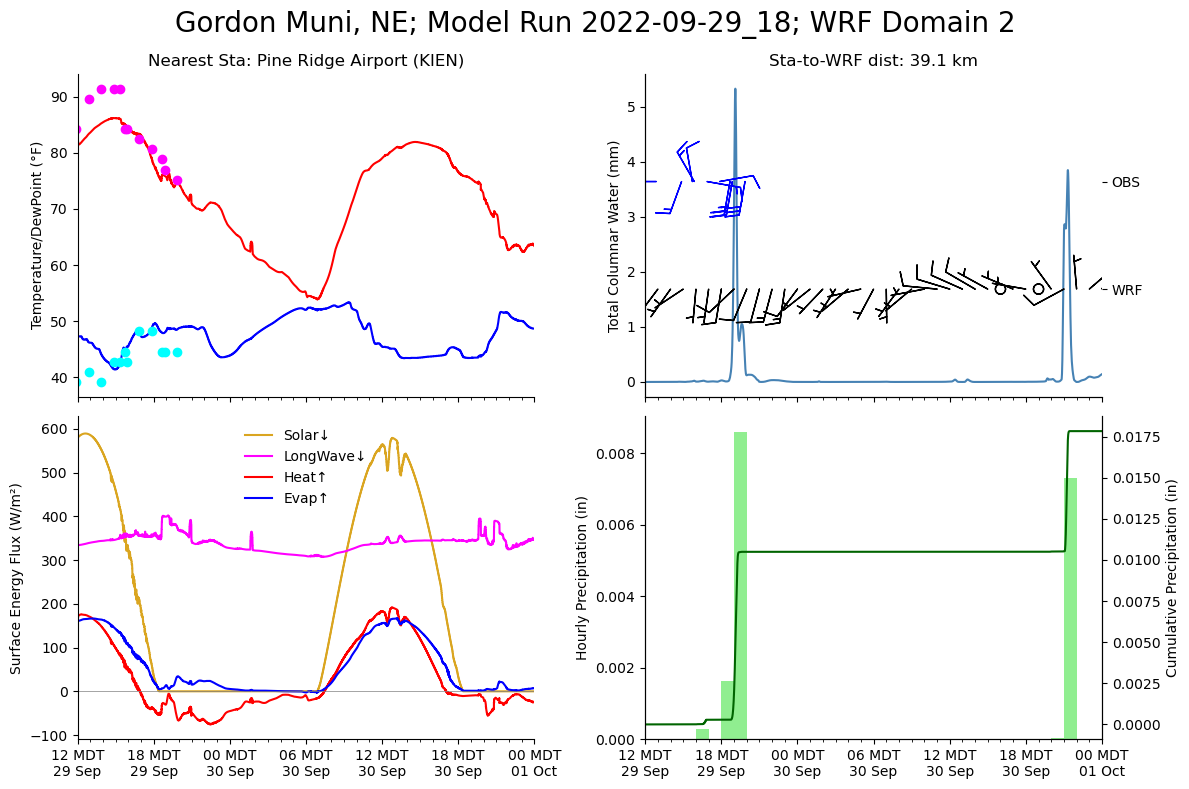

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_K4MC.nc
Weatherstation from airport database  Gillette Campbell County Airport
lon metar/station/wrf: -105.55 -104.95 [-104.936]
lat metar/station/wrf: 44.33 44.267 [44.26]
distance between  metar and tslist  48.26113979581281
distance between  metar and    wrf  49.483099036471195
distance between tslist and    wrf  1.3596715726410535
DatetimeIndex(['2022-09-29 11:53:00-06:00', '2022-09-29 12:53:00-06:00',
               '2022-09-29 13:53:00-06:00', '2022-09-29 14:53:00-06:00',
               '2022-09-29 15:53:00-06:00', '2022-09-29 16:53:00-06:00',
               '2022-09-29 17:53:00-06:00', '2022-09-29 18:53:00-06:00',
               '2022-09-29 19:53:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='date_time', freq=None)
                    station_id  latitude  longitude  elevation  \
date_time                                              

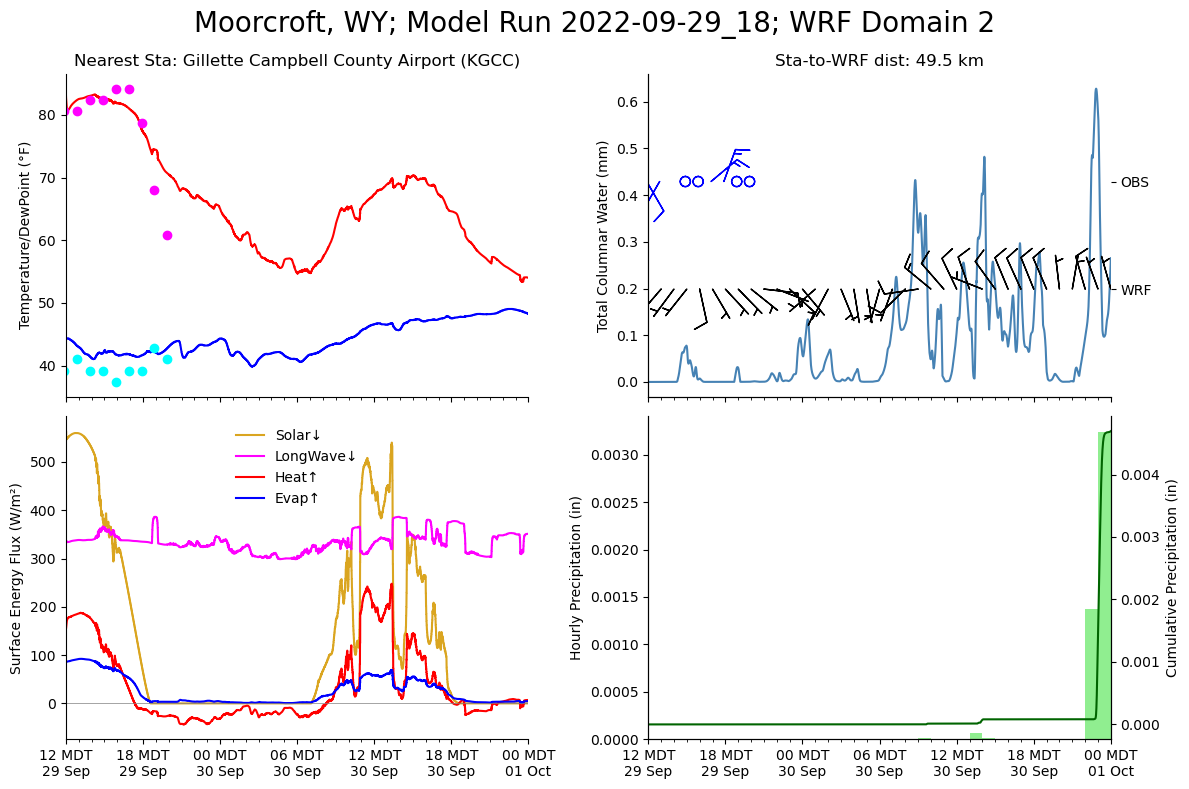

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KHEI.nc
Weatherstation from airport database  Hettinger Municipal Airport
lon metar/station/wrf: -102.65 -102.65 [-102.672]
lat metar/station/wrf: 46.02 46.017 [46.008]
distance between  metar and tslist  0.3335852407011438
distance between  metar and    wrf  2.160266374359072
distance between tslist and    wrf  1.9717894435592607
DatetimeIndex(['2022-09-29 11:53:00-06:00', '2022-09-29 12:53:00-06:00',
               '2022-09-29 13:53:00-06:00', '2022-09-29 14:53:00-06:00',
               '2022-09-29 15:53:00-06:00', '2022-09-29 16:53:00-06:00',
               '2022-09-29 17:53:00-06:00', '2022-09-29 18:53:00-06:00',
               '2022-09-29 19:53:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='date_time', freq=None)
                    station_id  latitude  longitude  elevation  \
date_time                                                  

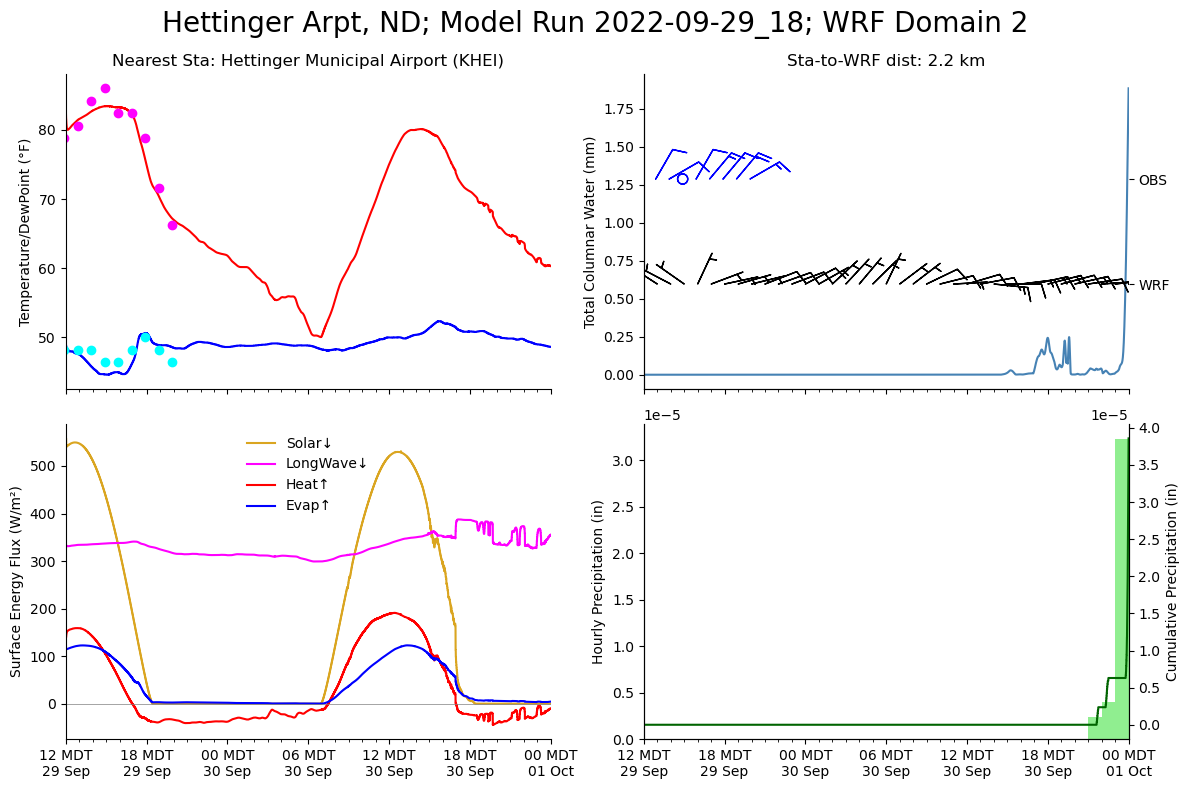

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2022-09-29_18_KAIA.nc
Weatherstation from airport database  Alliance Municipal Airport
lon metar/station/wrf: -102.8 -102.8 [-102.75]
lat metar/station/wrf: 42.05 42.05 [42.042]
distance between  metar and tslist  0.0
distance between  metar and    wrf  4.223458242464319
distance between tslist and    wrf  4.223458242464319
DatetimeIndex(['2022-09-29 11:53:00-06:00', '2022-09-29 12:53:00-06:00',
               '2022-09-29 13:53:00-06:00', '2022-09-29 14:53:00-06:00',
               '2022-09-29 15:53:00-06:00', '2022-09-29 16:53:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='date_time', freq=None)
                    station_id  latitude  longitude  elevation  \
date_time                                                        
2022-09-29 17:53:00       KAIA     42.05     -102.8     1196.0   
2022-09-29 18:53:00       KAIA     42.05     -102.8     1196.0   

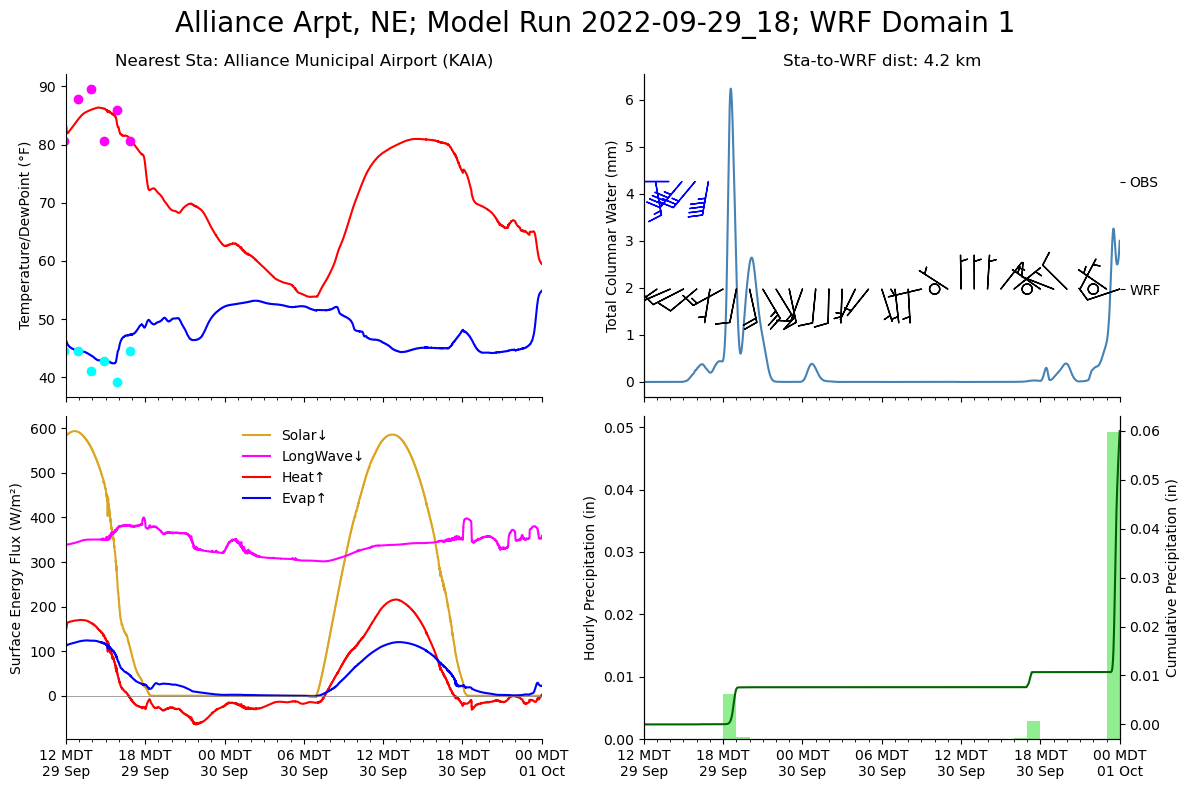

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KBWW.nc
Weatherstation from short table  KBWW
lon metar/station/wrf: -103.3 -103.3 [-103.295]
lat metar/station/wrf: 46.166666666666664 46.1655 [46.168]
distance between  metar and tslist  0.12972759360545022
distance between  metar and    wrf  0.4126007808138126
distance between tslist and    wrf  0.47490909768327155
DatetimeIndex(['2022-09-29 11:55:00-06:00', '2022-09-29 12:15:00-06:00',
               '2022-09-29 12:35:00-06:00', '2022-09-29 12:55:00-06:00',
               '2022-09-29 13:15:00-06:00', '2022-09-29 13:35:00-06:00',
               '2022-09-29 13:55:00-06:00', '2022-09-29 14:15:00-06:00',
               '2022-09-29 14:35:00-06:00', '2022-09-29 14:55:00-06:00',
               '2022-09-29 15:15:00-06:00', '2022-09-29 15:35:00-06:00',
               '2022-09-29 15:55:00-06:00', '2022-09-29 16:15:00-06:00',
               '2022-09-29 16:35:00-06:00', '20

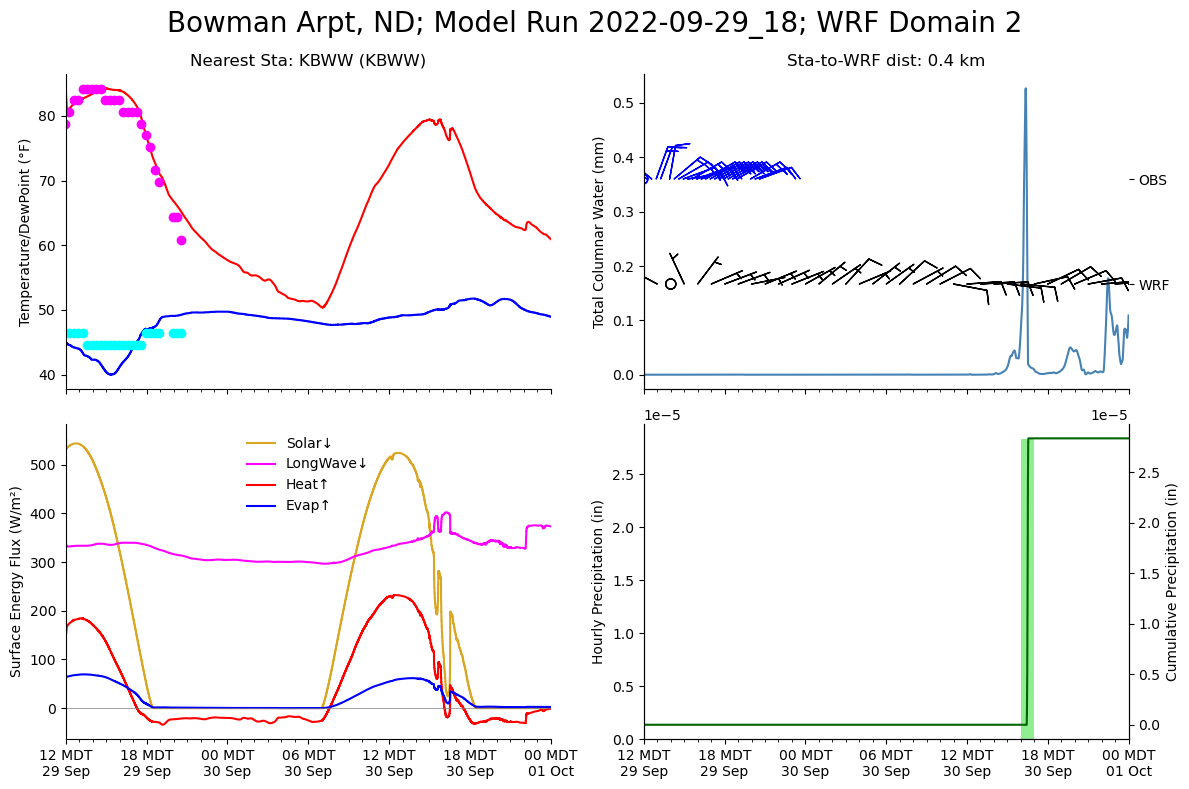

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KY22.nc
Weatherstation from airport database  Hettinger Municipal Airport
lon metar/station/wrf: -102.65 -102.167 [-102.168]
lat metar/station/wrf: 46.02 45.933 [45.926]
distance between  metar and tslist  38.557261903959926
distance between  metar and    wrf  38.687734631025755
distance between tslist and    wrf  0.7821985495285048
DatetimeIndex(['2022-09-29 11:53:00-06:00', '2022-09-29 12:53:00-06:00',
               '2022-09-29 13:53:00-06:00', '2022-09-29 14:53:00-06:00',
               '2022-09-29 15:53:00-06:00', '2022-09-29 16:53:00-06:00',
               '2022-09-29 17:53:00-06:00', '2022-09-29 18:53:00-06:00',
               '2022-09-29 19:53:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='date_time', freq=None)
                    station_id  latitude  longitude  elevation  \
date_time                                                

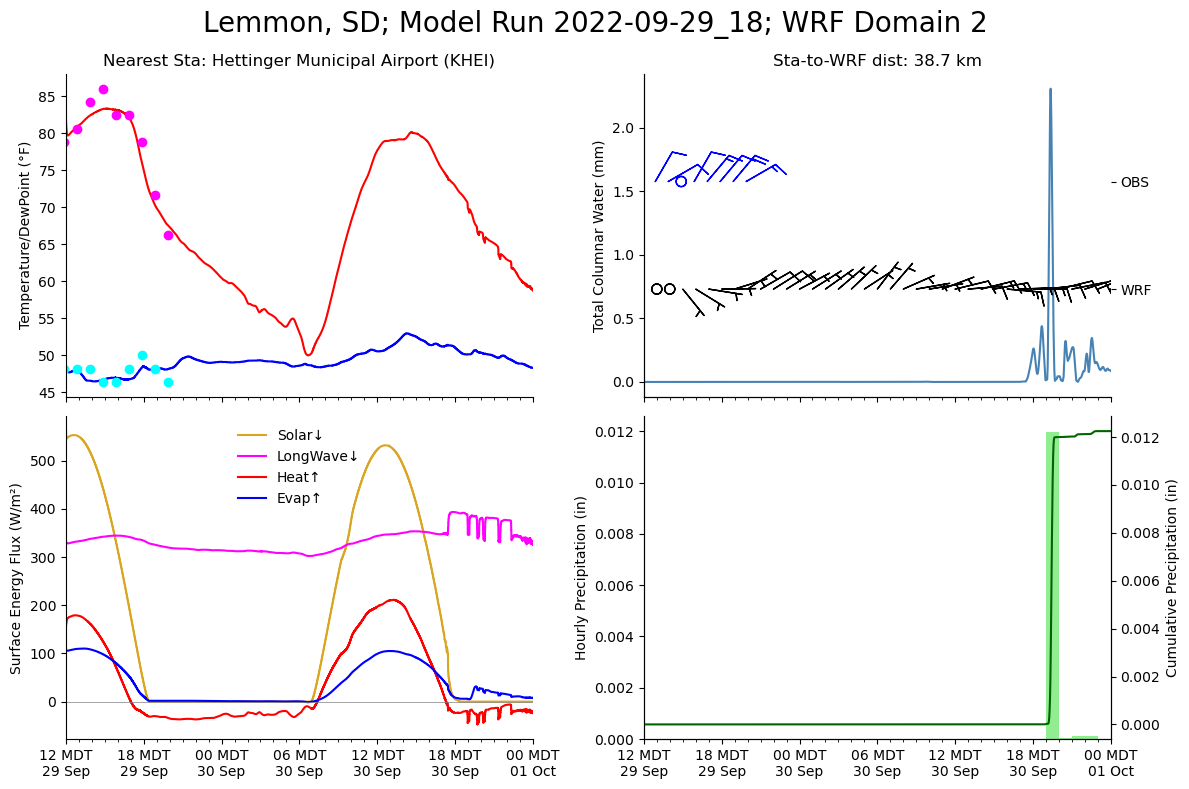

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KLEM.nc
Weatherstation from airport database  Hettinger Municipal Airport
lon metar/station/wrf: -102.65 -102.106 [-102.091]
lat metar/station/wrf: 46.02 45.919 [45.925]
distance between  metar and tslist  43.51717474448776
distance between  metar and    wrf  44.472737760913525
distance between tslist and    wrf  1.3384116227940177
DatetimeIndex(['2022-09-29 11:53:00-06:00', '2022-09-29 12:53:00-06:00',
               '2022-09-29 13:53:00-06:00', '2022-09-29 14:53:00-06:00',
               '2022-09-29 15:53:00-06:00', '2022-09-29 16:53:00-06:00',
               '2022-09-29 17:53:00-06:00', '2022-09-29 18:53:00-06:00',
               '2022-09-29 19:53:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='date_time', freq=None)
                    station_id  latitude  longitude  elevation  \
date_time                                                 

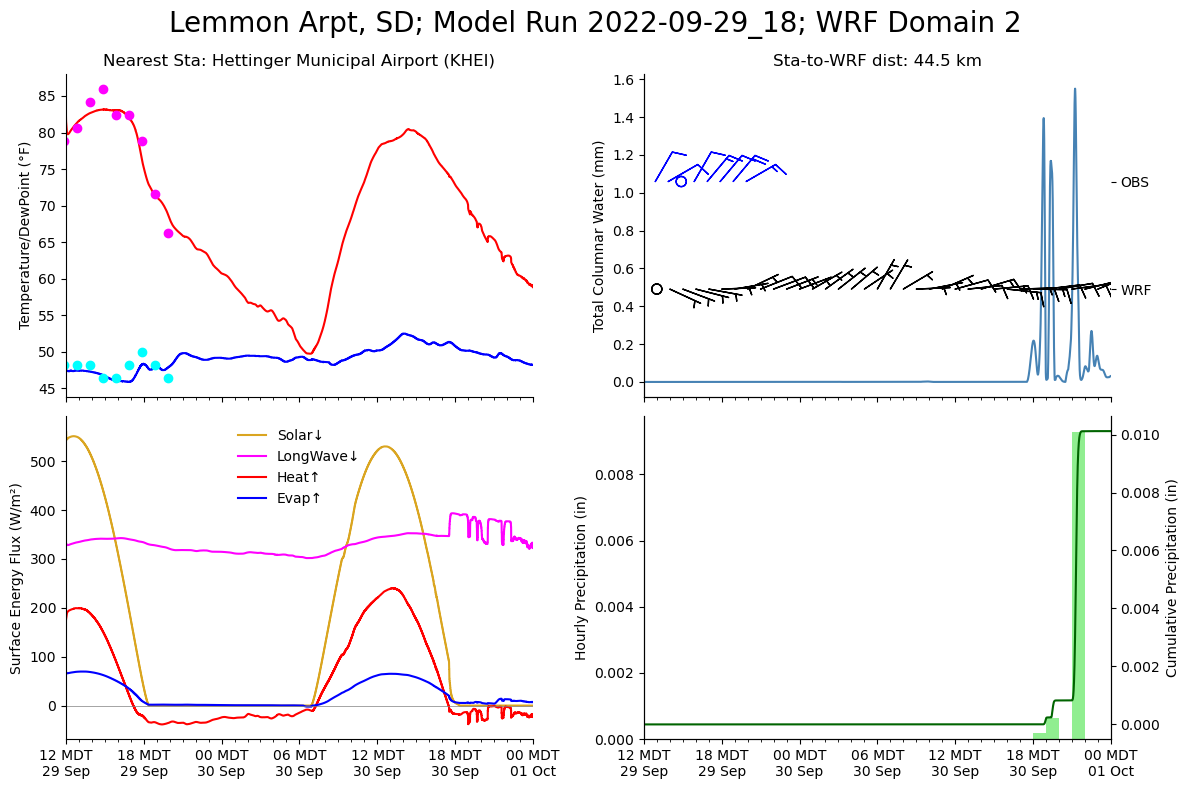

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2022-09-29_18_KTOR.nc
Weatherstation from airport database  Torrington Municipal Airport
lon metar/station/wrf: -104.15 -104.158 [-104.166]
lat metar/station/wrf: 42.07 42.061 [42.033]
distance between  metar and tslist  1.1990116491734861
distance between  metar and    wrf  4.321114013774105
distance between tslist and    wrf  3.1827689534592194
DatetimeIndex(['2022-09-29 11:53:00-06:00', '2022-09-29 12:53:00-06:00',
               '2022-09-29 13:53:00-06:00', '2022-09-29 14:53:00-06:00',
               '2022-09-29 15:53:00-06:00', '2022-09-29 16:53:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='date_time', freq=None)
                    station_id  latitude  longitude  elevation  \
date_time                                                        
2022-09-29 17:53:00       KTOR     42.07    -104.15     1277.0   
2022-09-29 18:53:00       KTOR     42.07  

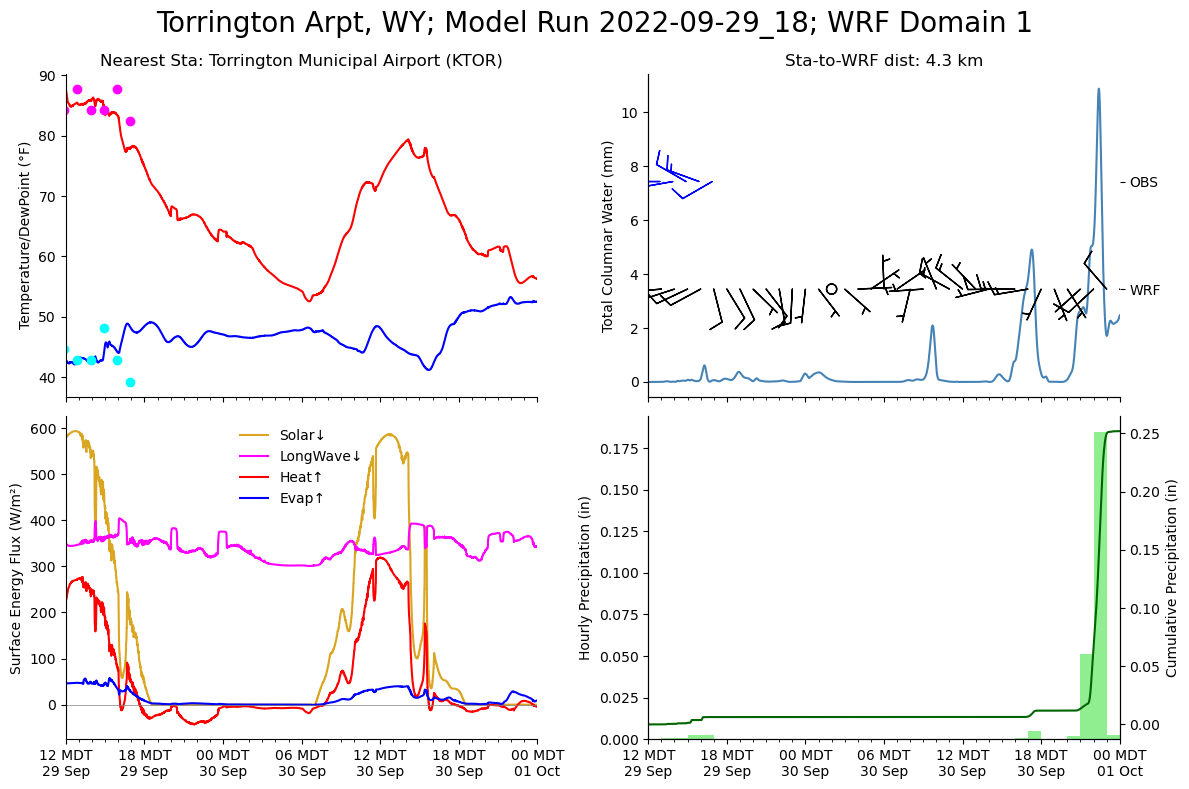

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2022-09-29_18_KBFF.nc
Weatherstation from airport database  Western Neb. Rgnl/William B. Heilig Airport
lon metar/station/wrf: -103.58 -103.593 [-103.619]
lat metar/station/wrf: 41.87 41.871 [41.877]
distance between  metar and tslist  1.0821540682942683
distance between  metar and    wrf  3.3216128092821107
distance between tslist and    wrf  2.253748255228174
DatetimeIndex(['2022-09-29 11:53:00-06:00', '2022-09-29 12:53:00-06:00',
               '2022-09-29 13:53:00-06:00', '2022-09-29 14:53:00-06:00',
               '2022-09-29 15:53:00-06:00', '2022-09-29 16:53:00-06:00',
               '2022-09-29 17:53:00-06:00', '2022-09-29 18:53:00-06:00',
               '2022-09-29 19:53:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='date_time', freq=None)
                    station_id  latitude  longitude  elevation  \
date_time                                 

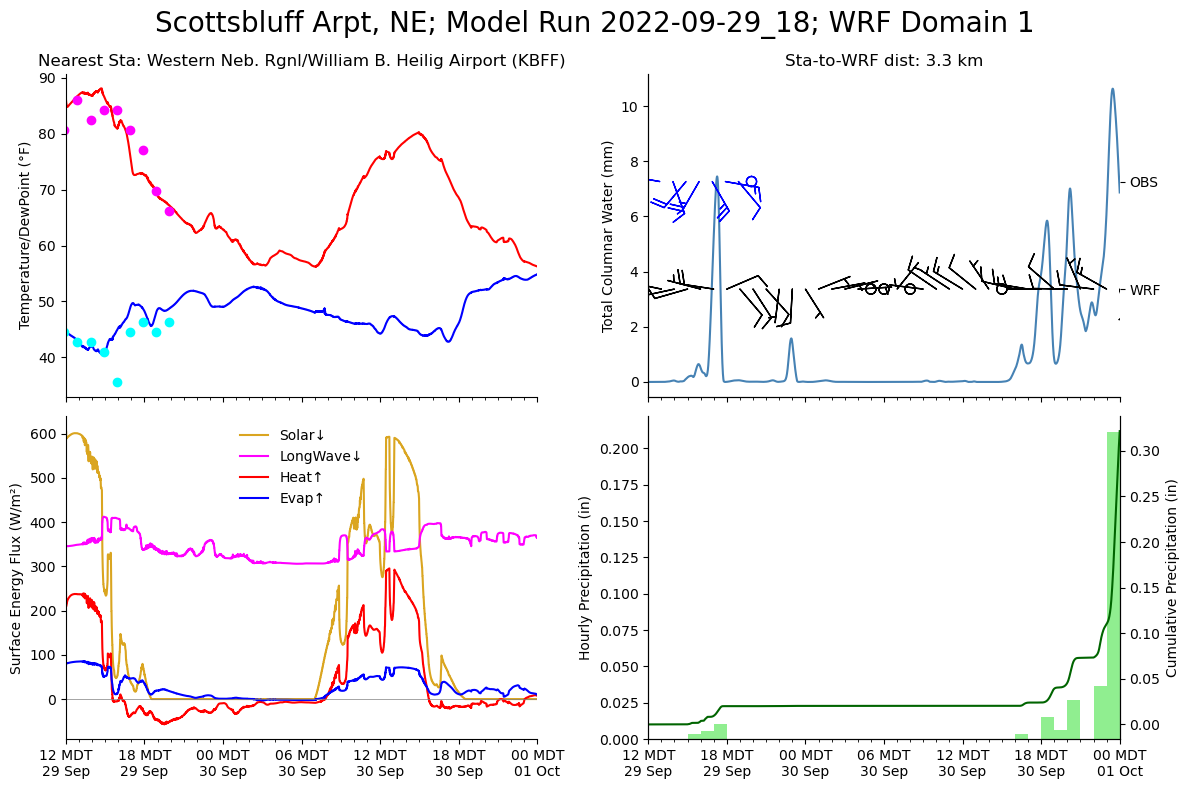

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KGCC.nc
Weatherstation from airport database  Gillette Campbell County Airport
lon metar/station/wrf: -105.55 -105.542 [-105.542]
lat metar/station/wrf: 44.33 44.339 [44.328]
distance between  metar and tslist  1.1859011529407848
distance between  metar and    wrf  0.6740792655015373
distance between tslist and    wrf  1.2231458825685029
DatetimeIndex(['2022-09-29 11:53:00-06:00', '2022-09-29 12:53:00-06:00',
               '2022-09-29 13:53:00-06:00', '2022-09-29 14:53:00-06:00',
               '2022-09-29 15:53:00-06:00', '2022-09-29 16:53:00-06:00',
               '2022-09-29 17:53:00-06:00', '2022-09-29 18:53:00-06:00',
               '2022-09-29 19:53:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='date_time', freq=None)
                    station_id  latitude  longitude  elevation  \
date_time                                           

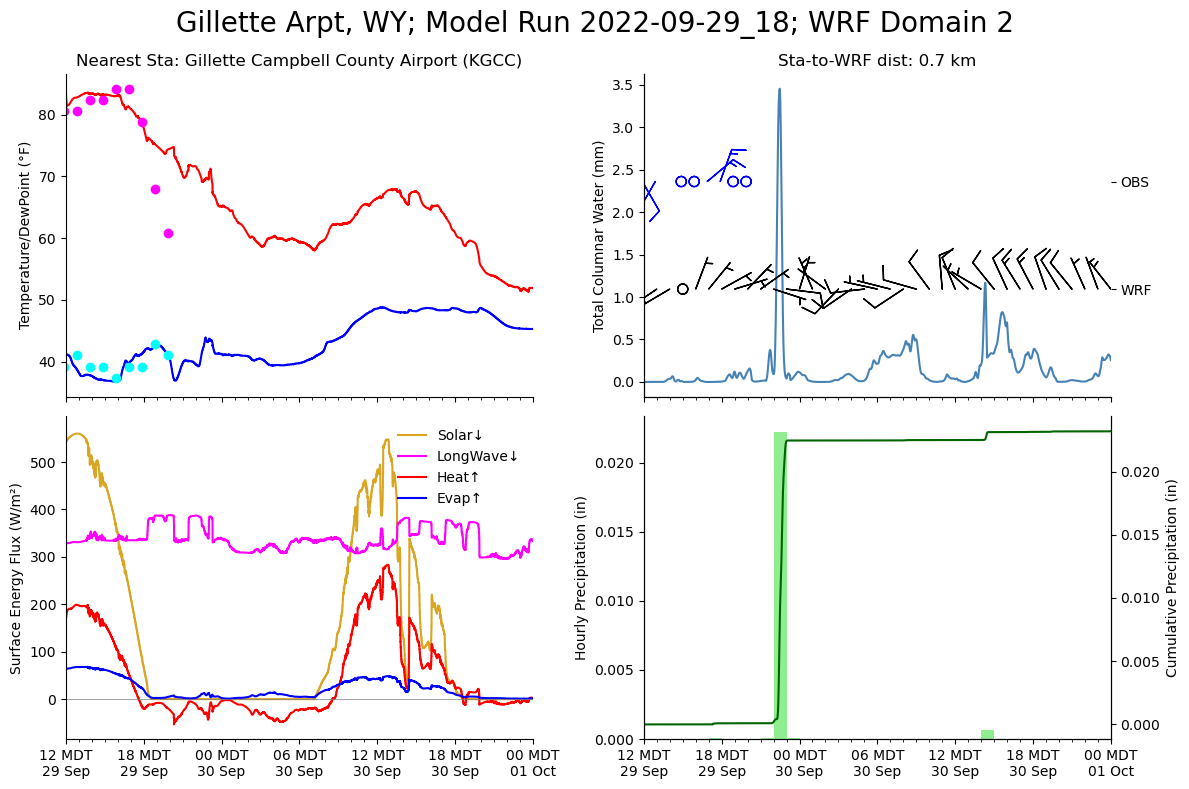

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d01_2022-09-29_18_KSIB.nc
Weatherstation from airport database  Torrington Municipal Airport
lon metar/station/wrf: -104.15 -105.033 [-105.052]
lat metar/station/wrf: 42.07 42.433 [42.423]
distance between  metar and tslist  83.1326823139916
distance between  metar and    wrf  83.98296190205724
distance between tslist and    wrf  1.9152799122335478
DatetimeIndex(['2022-09-29 11:53:00-06:00', '2022-09-29 12:53:00-06:00',
               '2022-09-29 13:53:00-06:00', '2022-09-29 14:53:00-06:00',
               '2022-09-29 15:53:00-06:00', '2022-09-29 16:53:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='date_time', freq=None)
                    station_id  latitude  longitude  elevation  \
date_time                                                        
2022-09-29 17:53:00       KTOR     42.07    -104.15     1277.0   
2022-09-29 18:53:00       KTOR     42.07    

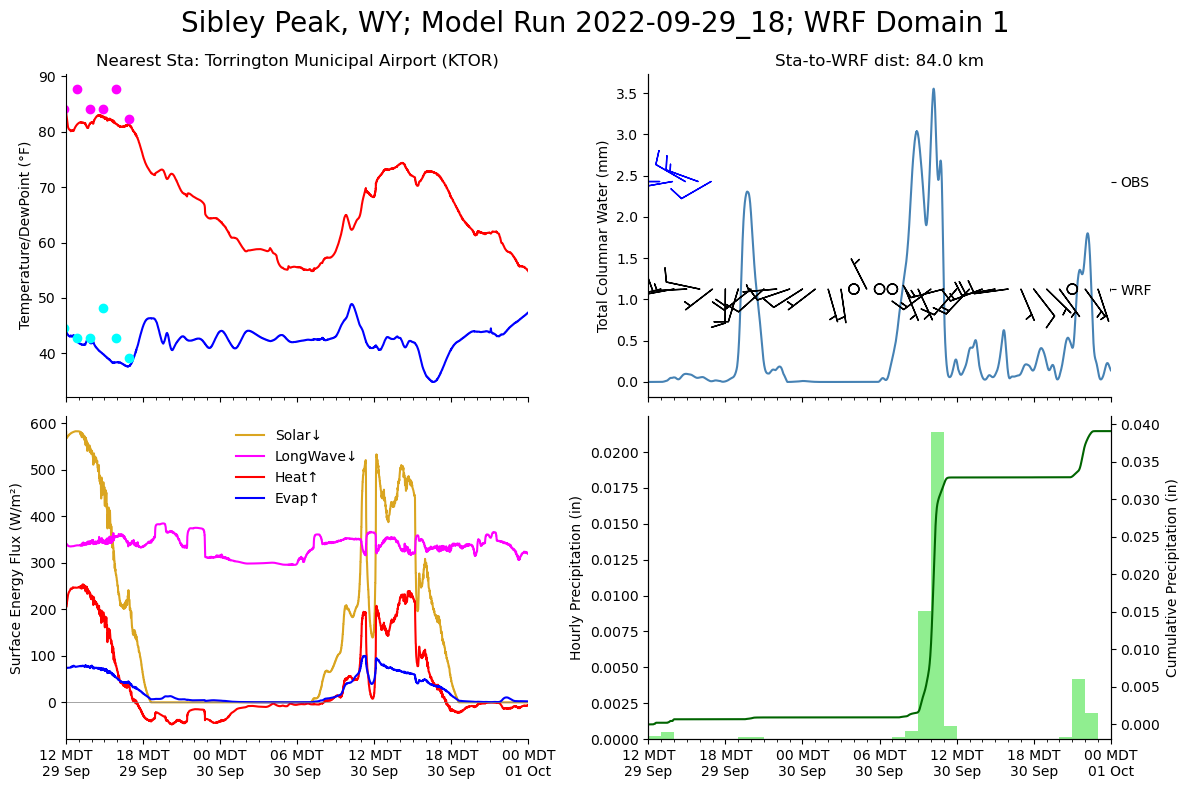

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2022-09-29_18_KDGW.nc
Weatherstation from airport database  Casper-Natrona County International Airport
lon metar/station/wrf: -106.47 -105.38 [-105.397]
lat metar/station/wrf: 42.9 42.796 [42.793]
distance between  metar and tslist  89.60964000839704
distance between  metar and    wrf  88.28197627899684
distance between tslist and    wrf  1.4266530683624203
DatetimeIndex(['2022-09-29 11:53:00-06:00', '2022-09-29 12:20:00-06:00',
               '2022-09-29 12:53:00-06:00', '2022-09-29 13:53:00-06:00',
               '2022-09-29 14:41:00-06:00', '2022-09-29 14:53:00-06:00',
               '2022-09-29 15:53:00-06:00', '2022-09-29 16:53:00-06:00',
               '2022-09-29 17:53:00-06:00', '2022-09-29 18:53:00-06:00',
               '2022-09-29 19:53:00-06:00'],
              dtype='datetime64[ns, America/Denver]', name='date_time', freq=None)
                    station_id  latitu

In [ ]:
####################################################
####################################################
####################################################
#
# Rotate through Available Files
#

file_time = model_start_datetime.strftime('%Y-%m-%d_%H')

TS_DIR    = WRF_ARCHIVE  + "./current_complete_run/STATION_TIME_SERIES/"

#
# Creating Graphics Directory
#

graphics_directory = WRF_IMAGES + "./current_complete_run/STATION_TIME_SERIES/"

print("Creating " + graphics_directory)

os.system("mkdir -pv " + graphics_directory )

#
# Start File Rotation
#

for station in available_time_series_list.iterrows():

    ###################################################################
    #
    # Pull Station Data 
    #

    station_id     = station[1][0]
    grid_domain    = station[1][1]
    station_name   = station[1][2]
    station_lat    = station[1][3]
    station_lon    = station[1][4]

    #    
    ###################################################################

    ###################################################################
    #
    # Pull WRF Time Series
    #
    
    netcdf_file_name = TS_DIR + "./wrfout_d"+str(grid_domain).zfill(2)+"_"+file_time+"_"+station_id+".nc"
    
    wrf_timeseries = xr.open_dataset(netcdf_file_name, 
                                     engine='netcdf4')
    
    print(netcdf_file_name)

    #
    ###################################################################

    ###################################################################
    #
    # Select Metars for Closest Station
    #

  

    ###################################################################
    #
    # Get METARS for Station 
    #
    


    #
    # Get Nearest Station to Requested Station Point
    #
    
    metar_station_locs['distance'] = metar_station_locs.apply(lambda row: haversine(row), axis=1)
    
    x=metar_station_locs[ metar_station_locs['distance'] == metar_station_locs['distance'].min() ]

    try:
        weather_station_name = airport_database[x['station_id'][0]]["name"] #+", "+airport_database[x['station_id'][0]]["subd"]
        print("Weatherstation from airport database ", weather_station_name)
    except KeyError:
        weather_station_name = x['station_id'][0]
        print("Weatherstation from short table ", weather_station_name)

               
    metar_data = metar_dataframe[metar_dataframe["station_id"]==x["station_id"][0]].set_index("date_time")
    

    
    
    print("lon metar/station/wrf:",metar_data["longitude"][0],station_lon,wrf_timeseries["wrf_grid_longitude"].values)
    print("lat metar/station/wrf:",metar_data["latitude"][0],station_lat,wrf_timeseries["wrf_grid_latitude"].values)

   

    metar_to_sta_distance  = hs.haversine((metar_data["latitude"][0],
                                           metar_data["longitude"][0]),
                                          (station_lat,
                                           station_lon))

    metar_to_wrf_distance = hs.haversine((metar_data["latitude"][0],
                                           metar_data["longitude"][0]),
                                          (wrf_timeseries["wrf_grid_latitude"].values,
                                           wrf_timeseries["wrf_grid_longitude"].values))


    sta_to_wrf_distance   = hs.haversine((station_lat,
                                          station_lon),
                                         (wrf_timeseries["wrf_grid_latitude"].values,
                                          wrf_timeseries["wrf_grid_longitude"].values))    
    
    print("distance between  metar and tslist ",metar_to_sta_distance)
    print("distance between  metar and    wrf ",metar_to_wrf_distance)
    print("distance between tslist and    wrf ",sta_to_wrf_distance)

    
    
    #    
    ###################################################################    

        







    #
    ###################################################################    
    

    ###################################################################
    ###################################################################
    #
    # Create Meteogram
    #

    ###################################################################
    #
    # Time Axes
    #
                                         
    tf     = tzf.TimezoneFinder()
    tz     = tf.certain_timezone_at(lng=station_lon, lat=station_lat)
    
    tzabbr = pytz.timezone(tz).localize(model_start_datetime)

    wrf_times  = pd.to_datetime(wrf_timeseries["time"]).tz_localize(tz="UTC").tz_convert(tz=tz)
    
    ncss_times = pd.to_datetime(metar_data.index).tz_localize(tz="UTC").tz_convert(tz=tz)



    wrf_time_seconds  =  wrf_times.minute*60+wrf_times.second 
    on_the_hour       = np.where(wrf_time_seconds ==0)
    wrf_time_hrly     = wrf_times[on_the_hour]
    wrf_time_hrly_bar = wrf_times[on_the_hour]-datetime.timedelta(minutes=30)

    #
    ###################################################################


    ###################################################################
    #
    # Precip Prep
    #

    wrf_cum_prec      = wrf_timeseries["stratiform_precipitation_amount"].values + wrf_timeseries["convective_precipitation_amount"].values
    wrf_cum_hrly_prec = wrf_cum_prec[on_the_hour]
    wrf_hrly_prec     = wrf_cum_hrly_prec.copy()

    wrf_hrly_prec[1:] = wrf_cum_hrly_prec[1:] - wrf_cum_hrly_prec[0:-1]
    
    wrf_hrly_prec     = wrf_hrly_prec     / 25.4
    wrf_cum_hrly_prec = wrf_cum_hrly_prec / 25.4
    wrf_cum_prec      = wrf_cum_prec      / 25.4

    #
    ###################################################################

    ###################################################################
    #
    # Wind Barb Prep
    #

    u_wrf = (wrf_timeseries["eastward_wind_10m"]*units("m")/units("s")).pint.to("knots")[on_the_hour]
    v_wrf = (wrf_timeseries["northward_wind_10m"]*units("m")/units("s")).pint.to("knots")[on_the_hour]



    obs_winddir   =  metar_data["wind_direction"].to_numpy() * units("deg")
    obs_windspeed = (metar_data["wind_speed"].to_numpy() * units("m")/units("s")).to("knots") 



    u_obs = (metar_data[ "eastward_wind"].to_numpy() * units("m")/units("s")).to("knots") 
    v_obs = (metar_data["northward_wind"].to_numpy() * units("m")/units("s")).to("knots") 

    #
    ###################################################################

    ###################################################################
    #
    # Plot Meteogram
    #

    fig, ax = plt.subplots(figsize = (12, 8),
                           nrows   =  2, 
                           ncols   =  2,
                           sharex  =  True)

    date_form = mdates.DateFormatter("%H %Z\n%d %b", tz=pytz.timezone(tz))
    xmajor = mdates.HourLocator(interval = 6)
    xminor = mdates.HourLocator(interval = 1)
    
    print(ncss_times)
    print(metar_data)
    
    

    #
    # Temperature and Humidity
    #
    
    ax[0,0].plot(wrf_times,
             (wrf_timeseries["air_temperature_2m"]*units("K")).pint.to("degF"),
              color = "red")
    ax[0,0].plot(wrf_times,
             (wrf_timeseries["dew_point_temperature_2m"]*units("K")).pint.to("degF"),
              color = "blue")
    ax[0,0].set_ylabel("Temperature/DewPoint (°F)")


    try:
        ax[0,0].plot(ncss_times,
                 (metar_data["air_temperature"].to_numpy()*units("degC")).to("degF"),
                 marker = "o",
                 color="magenta",
                linestyle = "None")
    except ValueError:
        print("balls: air_temperature plot error")

    try:
        ax[0,0].plot(ncss_times,
                 (metar_data["dew_point_temperature"].to_numpy()*units("degC")).to("degF"),
                 marker = "o",
                 color="cyan",
                linestyle = "None")
    except ValueError:
        print("balls: dew_point_temperature plot error")


    ax[0,1].set_title("Sta-to-WRF dist: "+str(round(metar_to_wrf_distance,1)) +" km")
    ax[0,0].set_title("Nearest Sta: "+weather_station_name +" ("+x['station_id'][0] +")")
        


    #
    # Total Atmos Column Water + Wind Speed
    #
    
    ax[0,1].plot(wrf_times,
            wrf_timeseries["atmosphere_mass_content_of_water"],
              color = "steelblue")
    ax[0,1].set_ylabel("Total Columnar Water (mm)")
 

    ax01 = ax[0,1].twinx()
    
    ax01.set_ylim(0,1)
    ax01.set_yticks([1/3.,2/3.])
    ax01.set_yticklabels(["WRF","OBS"])

    
    ax01.barbs( wrf_time_hrly, 1/3.,  u_wrf, v_wrf )

    try:
        ax01.barbs( ncss_times,    2/3.,  u_obs, v_obs, color="blue")
    except ValueError:
        print("balls: wind plotting error")

   
    
    #
    # Surface Energy Budget
    #

    ax[1,0].plot(wrf_times,
                 wrf_timeseries["surface_net_downward_shortwave_flux"],
                 color = "goldenrod")
    ax[1,0].plot(wrf_times,
                 wrf_timeseries["surface_net_downward_longwave_flux"],
                 color = "magenta")
    ax[1,0].plot(wrf_times,
                 wrf_timeseries["surface_upward_sensible_heat_flux"],
                 color = "red")
    ax[1,0].plot(wrf_times,
                 wrf_timeseries["surface_upward_latent_heat_flux"],
                 color = "blue")
    ax[1,0].legend(["Solar↓",
                    "LongWave↓",
                    "Heat↑",
                    "Evap↑"],
                  frameon=False)
    ax[1,0].set_ylabel("Surface Energy Flux (W/m²)")

    ax[1,0].axhline(y=0,color="grey", linewidth=0.5)
 
    #
    # Precipitation
    #

    ax[1,1].bar(wrf_time_hrly_bar,
                wrf_hrly_prec,
                linewidth=0,
                width=1/24, 
                color="lightgreen",
                edgecolor=None)
    ax11 = ax[1,1].twinx()
    ax11.plot(wrf_times,
              wrf_cum_prec, 
              color="darkgreen")
    ax11.set_ylabel("Cumulative Precipitation (in)")
    ax[1,1].set_ylabel("Hourly Precipitation (in)")

    fig.suptitle(station_name+"; Model Run "+file_time+"; WRF Domain "+str(grid_domain),
                 fontsize=20)


    ax[1,0].set_xlim(model_start_datetime, model_end_datetime)
    ax[1,0].xaxis.set_major_formatter(date_form)
    ax[1,0].xaxis.set_major_locator(xmajor)
    ax[1,0].xaxis.set_minor_locator(xminor)
    ax[1,0].xaxis_date()

    ax[1,1].set_xlim(model_start_datetime, model_end_datetime)
    ax[1,1].xaxis.set_major_formatter(date_form)
    ax[1,1].xaxis.set_major_locator(xmajor)
    ax[1,1].xaxis.set_minor_locator(xminor)
    ax[1,1].xaxis_date()

    ax[0,0].set_xlim(model_start_datetime, model_end_datetime)
    ax[0,0].xaxis.set_major_formatter(date_form)
    ax[0,0].xaxis.set_major_locator(xmajor)
    ax[0,0].xaxis.set_minor_locator(xminor)
    ax[0,0].xaxis_date()

    ax[0,1].set_xlim(model_start_datetime, model_end_datetime)
    ax[0,1].xaxis.set_major_formatter(date_form)
    ax[0,1].xaxis.set_major_locator(xmajor)
    ax[0,1].xaxis.set_minor_locator(xminor)
    ax[0,1].xaxis_date()

    ax[0,0].spines["top"].set_visible(False)
    ax[1,0].spines["top"].set_visible(False)
    ax[0,1].spines["top"].set_visible(False)
    ax[1,1].spines["top"].set_visible(False)
    ax11.spines[   "top"].set_visible(False)
    ax01.spines[   "top"].set_visible(False)

    ax[0,0].spines["right"].set_visible(False)
    ax[1,0].spines["right"].set_visible(False)
    ax[0,1].spines["right"].set_visible(False)
    ax01.spines[   "right"].set_visible(False)

    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)


    # plt.show()
    if (platform.system() != "Darwin"):
        fig.savefig(graphics_directory + "./wrfout_dxx_"+file_time+"_"+station_id+".png",
                        facecolor   = 'white', 
                        transparent =   False)
    else:
        plt.show()

    plt.close('all')


    #
    ###################################################################

    #
    ###################################################################
    ###################################################################
    
    print(" ")



## Depart 

In [ ]:
####################################################
####################################################
####################################################
#
# End of Script
#

print("Ploting Meteogram Script complete.")

#
####################################################
####################################################
####################################################